## Investigation of the VAB outcome: the connectome-based analysis

The current notebook explores the resting-state simulation results for the entire cohort of the 1000BRAINS dataset [(Caspers et al., 2014)](https://www.frontiersin.org/articles/10.3389/fnagi.2014.00149/full) based on empirical connectomes. 

We are going to provide details on the following topics:

1. The output of the parameter sweep for a couple of example subject
2. The age-related trends of the functional changes for the empirical and simulated data
3. The age-related dynamical variability landscape for the entire cohort and the trend of $G$ modulation
4. The relationship of the global $G$ with sex and cognitive scores

### Data alert 

The current notebook assumes that the dataset is located in the folder `$MYPATH/aging_virtual_brain/data/external` and the simulated dataset is located in the folder `$MYPATH/aging_virtual_brain/data/interim`. First, verify that the dataset is present before running any codeblock.

The access to this dataset is regulated by the EBRAINS platform. Therefore, any user must register to EBRAINS and request the access to dataset on the same platform by accepting the Data Users Agreement, which is a valid MTA.

Once registered, the access to this dataset is protected by the Human Data Gateway, and has to be explicitly requested. Please click the following link: [request access](https://data-proxy.ebrains.eu/datasets/83407c06-b494-4307-861e-d06a5aecdf8a). When granted, the right to access lasts 24 hours.

Alternatively, the access request link can be found in the Knowledge Graph page of the dataset under the *Get data* menu item: https://doi.org/10.25493/6640-3XH.

<div>
<img src="image_1000BD_EBRAINS.png" width="1000"/>
</div>

Have you download the data according to the suggested procedure? If yes, go ahead. If no, 
### ***Re-read carefully the data alert block***

### Import packages

Import the most useful packages for this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

from src import data, analysis, simulation, FC_analysis, viz, Burstiness 
from tvb.datatypes.time_series import *

from scipy.io.matlab import loadmat
from tvb.simulator.lab import *

LOG = get_logger('demo')

import scipy.stats

import time
import resource
from sys import getsizeof
import pandas as pd
import os
from scipy import stats
import numpy.matlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re
from pingouin import ancova
from pingouin import partial_corr
import warnings
warnings.filterwarnings("ignore")

/Users/mariolavanga/Documents/GitHub/ageing_virtual_brain/env/lib/python3.7/site-packages/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


The next codeblock uploads the 1000BRAINS dataset, the list of regions and the list of metadata of each subject. Please pay attention that the code uploads both the list of subjs of the folder and the list of all 1000BRAINS subjects of the study (available in csv). Do refer to the variable subjs and the sorted output based on the available data in the folder.

If you have downloaded the data correctly (see ***Data Alert*** block), the codeblock should not give any error message

We have also restricted the subjects for the first half of this notebook to guarantee a fast check of the paramter sweep output based on the empirical connectomes. If the user wishes to explore the sweep of each subject, it can replace the variable `P_LIST` with `subjs`.

In [2]:
# Upload Julich dataset, the list of regions and the list of metadata of each patient. Please pay attention that the code uploads both 
# subjs list of the folder and the subj list of csv. Do refer to the variable subjs and the sorted output based on the available data in the folder
separator = ''
jul    = data.Julich() 
# subjs  = jul.list_subjects()
parce_list = jul.parcellation_100()
#subj_age,gender,education,subj_ID = jul.metadata()
subj_age,gender,education,subj_ID,age_sort,gender_sort,gender_sort,subjs = jul.metadata()
subjs      = jul.list_subjects()
P_LIST     = ['sub-0024','sub-0947']

The codeblock below defines the ranges of the parameter sweep: $G = [1.5 - 3.2]$ and $\sigma^2 = [0.01-0.05]$

In [3]:
G_VECT     = np.arange(1.5,3.25,0.05)
G_TAU      = list(G_VECT.round(7))
N_VECT     = np.array([0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.045,0.05])
N_TAU      = list(N_VECT.round(7))
ALPHA1     = 0.0
ALPHA2     = 0.0
BOLD_TR    = 2200

The following functions allow to collect the demographic data, the BOLD time series and the summary statistics to describe the static FC and FCD with age.  

The output of snakemake listing is a set of files with the following name pattern

`julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_cohort_heun.npz` or `julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_cohort_heun.npz`

The variable $\alpha_2$ relates to a second distorsion pattern that we did not test in the current VAB implementation. Therefore, its value is set to zero ($\alpha_2=0$). 

These simulated data files are considered intermediate results file and they are located in the folder `$MYPATH/aging_virtual_brain/data/interim`. Intermediate results are also considered personal data, therefore 

### ***Re-read carefully the data alert block***

These simulated data files are considered intermediate results file and they are located in the folder `$MYPATH/aging_virtual_brain/data/interim`. Intermediate results are also considered personal data, therefore 

### ***Re-read carefully the data alert block***

In [4]:
def collect_usage(G,noise,mysubj,alpha1,alpha2):
    
    separator       = ''
    
    str_save        = separator.join(['interim/virtual_cohort_heun_100_interface_MERGE_SECOND/julich_data_group_rs','_pat',f"{mysubj}",'_G',f"{G}",'_nsigma',f"{noise}",'_alpha1',f"{alpha1}",'_alpha2',f"{alpha2}",'_cohort_heun.npz'])

    out_path        = os.path.join(jul.data_root,str_save)
    
    output_data     = np.load(out_path)
    
    return output_data

In [5]:
def collect_demo(G,noise,mysubj,alpha1,alpha2):
    
    output_data     = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    mysubj          = output_data['mysubj']
    myage           = output_data['myage']
    
    
    return mysubj,myage

In [6]:
def collect_bold(G,noise,mysubj,alpha1,alpha2):
    
    output_data     = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    bold            = output_data['Bold_data'][:,0,:,0]
    time_bold       = output_data['Bold_time']
    
    return bold,time_bold

In [7]:
def collect_FCD_OV(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    FCD_SUM_OV_vect    = output_data['FCD_SUM_OV_vect']
    FCD_MEAN_OV_vect   = output_data['FCD_MEAN_OV_vect']
    FCD_VAR_OV_vect    = output_data['FCD_VAR_OV_vect']
    FCD_OSC_OV_vect    = output_data['FCD_OSC_OV_vect']
    
    
    return FCD_SUM_OV_vect,FCD_MEAN_OV_vect,FCD_VAR_OV_vect,FCD_OSC_OV_vect

In [8]:
def collect_FCD_OV_INTER(G,noise,mysubj,alpha1,alpha2):
    
    output_data = collect_usage(G,noise,mysubj,alpha1,alpha2)
    
    FCD_SUM_OV_INTER_vect    = output_data['FCD_SUM_OV_INTER_vect']
    FCD_MEAN_OV_INTER_vect   = output_data['FCD_MEAN_OV_INTER_vect']
    FCD_VAR_OV_INTER_vect    = output_data['FCD_VAR_OV_INTER_vect']
    FCD_OSC_OV_INTER_vect    = output_data['FCD_OSC_OV_INTER_vect']
    
    
    return FCD_SUM_OV_INTER_vect,FCD_MEAN_OV_INTER_vect,FCD_VAR_OV_INTER_vect,FCD_OSC_OV_INTER_vect

## 1. Parameter sweep output and functional features collection

The fludity landscape or the parameter map is a 315 entries grid of $\sigma^2(FCD)$, where the two dimensions are represented by two parameter range: $G = [1.5 - 3.2]$ and $\sigma^2 = [0.01-0.05]$. We can collect the entries with a two nested for loops. At the same time, we can also collect the two main target functional features of our analysis, which are the average Homotopic FC, $<Homotopic_{FC}>$, and the FCD variance difference, $\sigma^2_{diff}$ (see details in the second part). Once all the maps are collect in array of matrices or a tensor, we can detect the maximum for each matrix and determine the pair of tuning paramters ($G$,$\sigma^2$) to simulate data for each subject and the associated BOLD data, $FCD$ and $FC$ matrices and the summary statistics ($<Homotopic_{FC}>$, $\sigma^2_{diff}$).

In [9]:
win_FCD              = 40e3

FC_TENSOR            = np.zeros([len(parce_list),len(parce_list),len(G_TAU),len(N_TAU),len(P_LIST)])
FC_EMP               = np.zeros([len(parce_list),len(parce_list),len(P_LIST)])


FCD_SUBJ_MEAN_OV_TENS            = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_VAR_OV_TENS             = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_STACK_STD_INTER_TENS         = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FCD_SUBJ_DIFF_VAR_OV_TENS        = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
HOMO_FC_TENS                     = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

FC_CORR             = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])
FS_CORR             = np.empty([len(G_TAU),len(N_TAU),len(P_LIST)])

FCD_SUBJ_MEAN_OV_TENS[:]         = np.nan
FCD_SUBJ_VAR_OV_TENS[:]          = np.nan
FCD_SUBJ_VAR_OV_TENS[:]          = np.nan
FCD_SUBJ_DIFF_VAR_OV_TENS[:]     = np.nan
HOMO_FC_TENS[:]                  = np.nan

FC_CORR[:]                  = np.nan
FS_CORR[:]                  = np.nan

FCD_MEAN_OV_EMP          = []
FCD_VAR_OV_EMP           = []
FCD_INTER_OSC_EMP        = []
FCD_SUBJ_DIFF_VAR_OV_EMP = []
HOMO_FC_EMP              = []

myage_list     = []
mysubj_list    = []

mygender_list  = []
myedu_list     = []

NHALF          = int(len(parce_list)/2)

mask_inter                              = np.zeros([NHALF*2,NHALF*2])
mask_inter[0:NHALF,NHALF:NHALF*2]       = 1
mask_inter[NHALF:NHALF*2,0:NHALF]       = 1

# for subj_idx in range(len(subjs)):
for subj_idx in range(len(P_LIST)):
    
    #     mysubj    = subjs[subj_idx]
    mysubj     = P_LIST[subj_idx]
    print(['SUBJ --> ',mysubj,'-->',str(subj_idx),'/',str(len(P_LIST))])
    bold_emp   = jul.load_subject_fc_100(mysubj)
    _,weights  = jul.load_subject_sc_100(mysubj)
    
    rsFC_emp   = np.corrcoef(bold_emp.T)
    rsFC_emp   = rsFC_emp * (rsFC_emp>0)
    rsFC_emp   = rsFC_emp - np.diag(np.diagonal(rsFC_emp))
    
    FC_FC_homo         =  np.diag(rsFC_emp,k=NHALF)

    HOMO_FC_EMP        += [np.mean(FC_FC_homo)]
    

    transient           = int(5e3/BOLD_TR)
    win_FCD             = 40e3
    
    FCD, fc_stack, speed_fcd      = analysis.compute_fcd(bold_emp[transient:,:], win_len=int(win_FCD/BOLD_TR), win_sp=1)
    fcd_inter, fc_stack_inter, _  = analysis.compute_fcd_filt(bold_emp[transient:,:],mask_inter,win_len=int(win_FCD/BOLD_TR),win_sp=1)
    
    FCD_TRIU_OV                = np.triu(FCD, k=int(win_FCD/2250))
    FCD_INTER_TRIU_OV          = np.triu(fcd_inter, k=int(win_FCD/2250))
    
    FCD_MEAN_OV_EMP            +=[np.mean(FCD_TRIU_OV)]
    FCD_VAR_OV_EMP             +=[np.var(FCD_TRIU_OV)]
    
    FCD_INTER_OSC_EMP          +=[np.std(fc_stack_inter)]

 
    FCD_SUBJ_DIFF_VAR_OV_EMP   +=[np.var(FCD_INTER_TRIU_OV)-np.var(FCD_TRIU_OV)]
    
    mysubj,myage               = collect_demo(G_TAU[0],N_TAU[0],mysubj,ALPHA1,ALPHA2)
    
    SUBJ_TARG     = [subj_loc for subj_loc in range(len(subj_ID)) if str(mysubj) in subj_ID[subj_loc] ][0]
    
    myage_list    +=[float(myage)]
    mysubj_list   +=[mysubj]
    myedu_list    +=[education[SUBJ_TARG]]
    mygender_list +=[gender[SUBJ_TARG]]
                        
    for n_idx in range(len(N_TAU)):
        for g_idx in range(len(G_TAU)):

            bold,time_bold             = collect_bold(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)

            transient = int(5e3/2000)
            bold_sig  = bold[transient:,:]

            rsFC      = np.corrcoef(bold_sig.T)
            rsFC      = rsFC * (rsFC>0)
            rsFC      = rsFC - np.diag(np.diagonal(rsFC))

            _,FCD_MEAN_OV,FCD_VAR_OV,_                                = collect_FCD_OV(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)
            _ ,_,FCD_VAR_OV_INTER ,FCD_OSC_OV_INTER         = collect_FCD_OV_INTER(G_TAU[g_idx],N_TAU[n_idx],mysubj,ALPHA1,ALPHA2)


            FCD_SUBJ_MEAN_OV_TENS[g_idx,n_idx,subj_idx]     = FCD_MEAN_OV[3]
            FCD_SUBJ_VAR_OV_TENS[g_idx,n_idx,subj_idx]      = FCD_VAR_OV[3]

            FCD_STACK_STD_INTER_TENS[g_idx,n_idx,subj_idx]  = FCD_OSC_OV_INTER[3]

            FCD_SUBJ_DIFF_VAR_OV_TENS[g_idx,n_idx,subj_idx] = FCD_VAR_OV_INTER[3] - FCD_VAR_OV[3]

            HOMO_FC_TENS[g_idx,n_idx,subj_idx]        = np.mean(np.diag(rsFC,k=NHALF))
            
            
print('END UPLOAD')




['SUBJ --> ', 'sub-0024', '-->', '0', '/', '2']
['SUBJ --> ', 'sub-0947', '-->', '1', '/', '2']
END UPLOAD


Here we show an example of FCD landscape for a target subject.

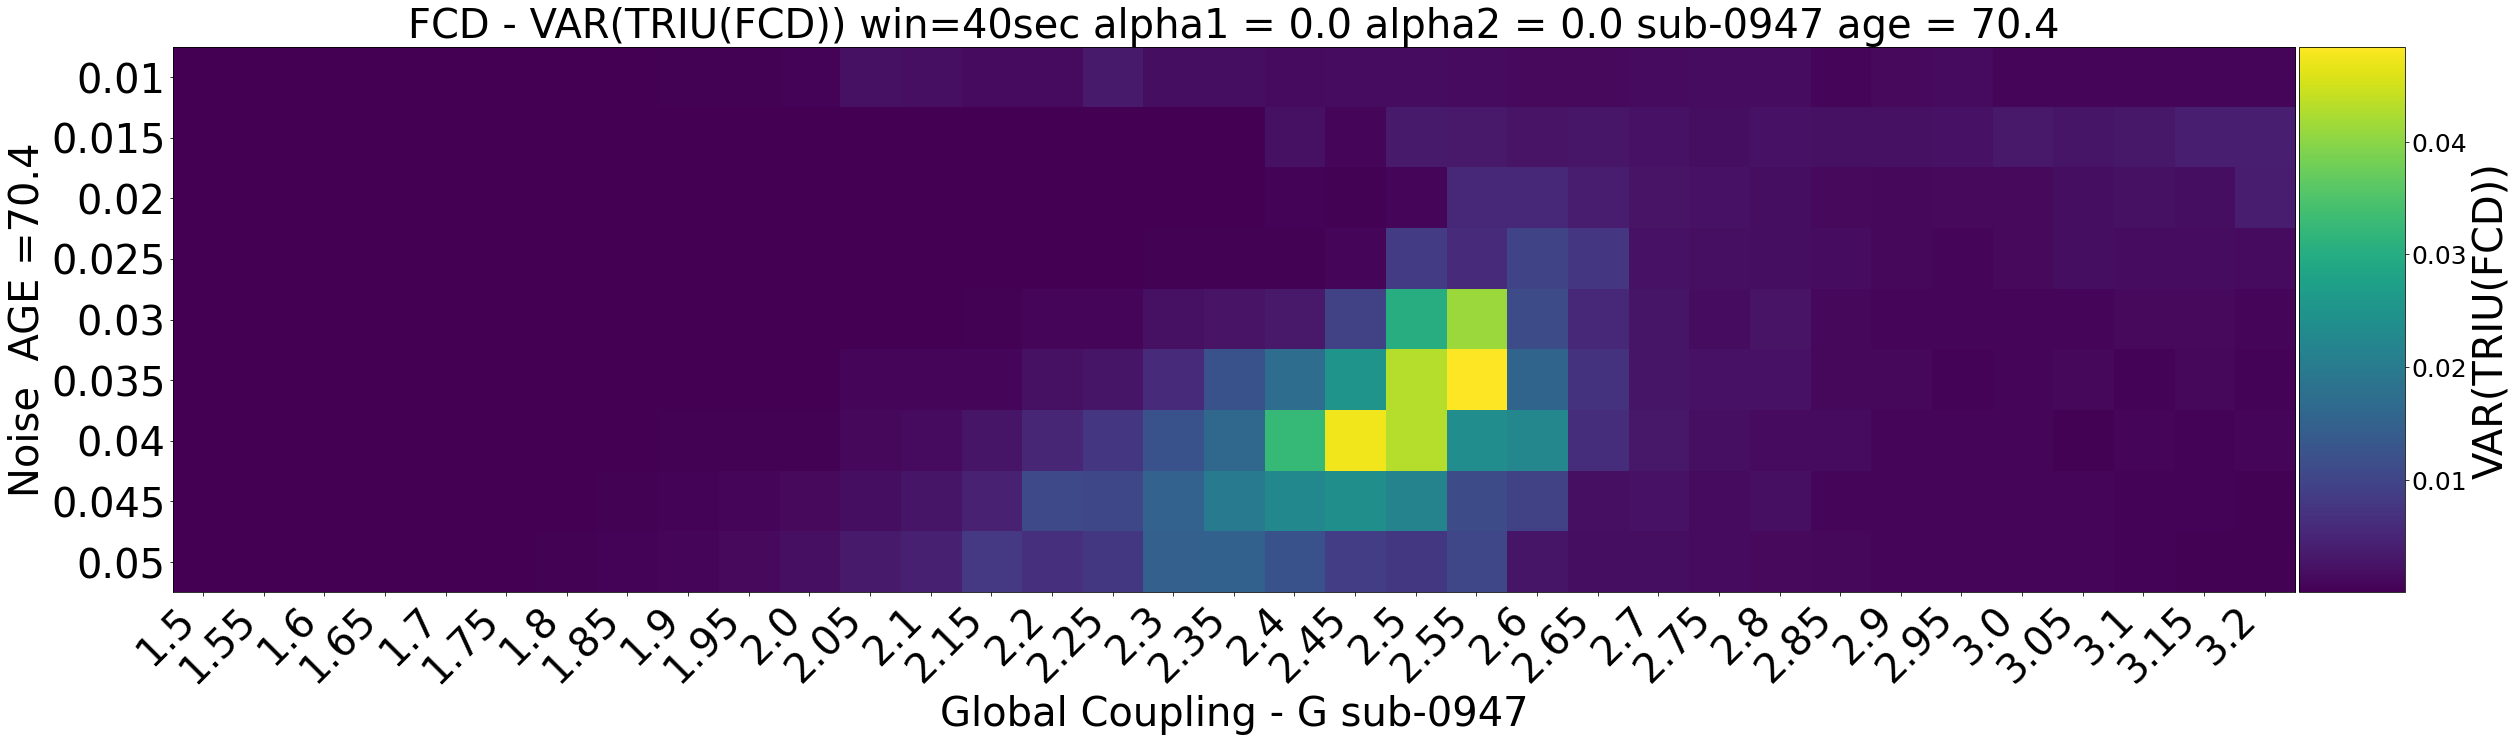

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

PAT_IDX = 1

mytit = separator.join(["FCD - VAR(TRIU(FCD)) win=40sec", ' alpha1 = ',str(ALPHA1),' alpha2 = ',str(ALPHA2),' ',P_LIST[PAT_IDX],' age = ',str(myage_list[PAT_IDX])])
stry  = separator.join(["Noise  AGE =",str(myage_list[PAT_IDX])])
strx  = separator.join(["Global Coupling - G ",str(mysubj_list[PAT_IDX])])

label_format = '{:,.001f}'
font_size = 25
f,ax = plt.subplots(figsize=(40,40))

image = ax.imshow(FCD_SUBJ_VAR_OV_TENS[:,:,PAT_IDX].T)

ax.set_ylabel(stry,fontsize=font_size+15)
ax.set_xlabel(strx,fontsize=font_size+15)
ax.tick_params(axis='x', labelsize=font_size+15)
ax.tick_params(axis='y', labelsize=font_size+15)
plt.xticks(range(len(G_TAU)),G_TAU,rotation = 45, ha="right")
plt.yticks(range(len(N_TAU)),N_TAU)
plt.title(mytit,fontsize=font_size+15)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("VAR(TRIU(FCD))",fontsize=font_size+15)
cbar.ax.tick_params(labelsize=font_size)

By scanning the FCD tensor ($age\times G \times \sigma^2$), we can determine the maximum of the landscape and the associated argument to determine the individual $G$, $\sigma^2$ and the target summary statistics.

In [11]:
FCD_MEAN_OV = []
FCD_VAR_OV  = []

FCD_DIFF_VAR_OV  = []

TUNE_FCD_MAX = np.zeros([len(P_LIST),2])

G_MAX        = []
N_MAX        = []
HOMO_FC      = []

FCD_STINTER_GIVEN_FCD = []
FCD_MEAN_OV           = []
FCD_VAR_OV            = []
FCD_DIFF_VAR_OV       = []
HOMO_FC               = []

FC_CORR_MAX           = []


# for subj_idx in range(len(subjs)):
for subj_idx in range(len(P_LIST)):
    
#     mysubj    = subjs[subj_idx]
    mysubj    = P_LIST[subj_idx]
    
    mymat                   = FCD_SUBJ_VAR_OV_TENS[:,:,subj_idx]   
    
    [GMAX_entry,NMAX_entry] = np.unravel_index(np.nanargmax(mymat, axis=None), mymat.shape)
    G_MAX +=[G_TAU[GMAX_entry]]
    N_MAX +=[N_TAU[NMAX_entry]]
    
    
    TUNE_FCD_MAX[subj_idx,0] = GMAX_entry
    TUNE_FCD_MAX[subj_idx,1] = NMAX_entry
    
    FCD_STINTER_GIVEN_FCD += [FCD_STACK_STD_INTER_TENS[GMAX_entry,NMAX_entry,subj_idx]]
    
    FCD_MEAN_OV           += [FCD_SUBJ_MEAN_OV_TENS[GMAX_entry,NMAX_entry,subj_idx]]
    FCD_VAR_OV            += [FCD_SUBJ_VAR_OV_TENS[GMAX_entry,NMAX_entry,subj_idx]]
    FCD_DIFF_VAR_OV       += [FCD_SUBJ_DIFF_VAR_OV_TENS[GMAX_entry,NMAX_entry,subj_idx]]
    HOMO_FC               += [HOMO_FC_TENS[GMAX_entry,NMAX_entry,subj_idx]]
    
    FC_CORR_MAX  += [np.nanmax(FC_CORR[:,:,subj_idx])]
    
    

Thanks to the chosen $G$ and the noise variance $\sigma^2$, we can plot the FCD matrix and the BOLD time series.

0.6387484284603079
2.45
0.03
0.03959032213148319


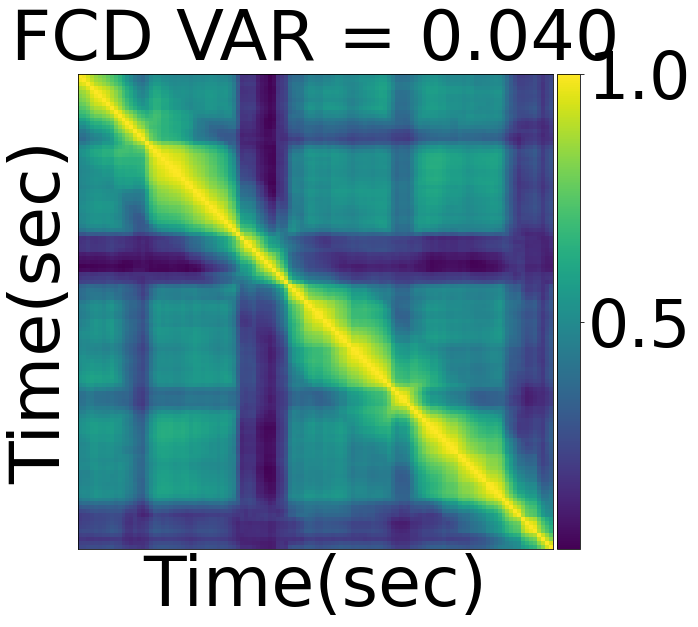

In [12]:
path_root  = os.path.dirname(os.getcwd())

# ALPHA1 = 0.8
# ALPHA2 = 0.2

PAT_IDX = 0

mysubj = P_LIST[PAT_IDX]
G_CHOS = int(TUNE_FCD_MAX[PAT_IDX,0])
N_CHOS = int(TUNE_FCD_MAX[PAT_IDX,1])


font_size = 60

win_FCD = 40e3

from mpl_toolkits.axes_grid1 import make_axes_locatable
bold,time_bold   = collect_bold(G_TAU[G_CHOS],N_TAU[N_CHOS],mysubj,ALPHA1,ALPHA2)
# bold             = jul.load_subject_fc_100(mysubj)
FCD, fc_stack, speed_fcd = analysis.compute_fcd(bold[10:,:], win_len=int(win_FCD/2000), win_sp=1)
# FCD_plot = np.triu(FCD, k=int(win_FCD/2000)) + np.tril(FCD, k=-int(win_FCD/2000))
FCD_plot = FCD
print(np.max(np.triu(FCD_plot, k=int(win_FCD/2000))))
f,ax = plt.subplots(figsize=(9,9))
image = ax.imshow(FCD_plot,vmax = 1.0)
ax.set_ylabel("Time(sec)",fontsize=font_size+10)
ax.set_xlabel("Time(sec)",fontsize=font_size+10)
ax.tick_params(axis='x', labelsize=font_size+5)
ax.tick_params(axis='y', labelsize=font_size+5)
ax.set_xticks([])
ax.set_yticks([])

mean_FCD = np.mean(np.triu(FCD_plot, k=int(win_FCD/2000)))
max_FCD = np.max(np.triu(FCD_plot, k=int(win_FCD/2000)))
var_FCD = np.var(np.triu(FCD_plot, k=int(win_FCD/2000)))
min_FCD = np.min(np.triu(FCD_plot, k=int(win_FCD/2000)))
separator = ''
str_title = separator.join(["FCD VAR = ",f"{var_FCD:.3f}"])
# str_title = separator.join(["FC Dynamics"])
plt.title(str_title,fontsize=font_size+10)
                         
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
# cbar.ax.set_ylabel("CORR(%)",fontsize=font_size+5)
cbar.ax.tick_params(labelsize=font_size+5)                 
        
print(G_TAU[G_CHOS]) 
print(N_TAU[N_CHOS])
print(var_FCD)

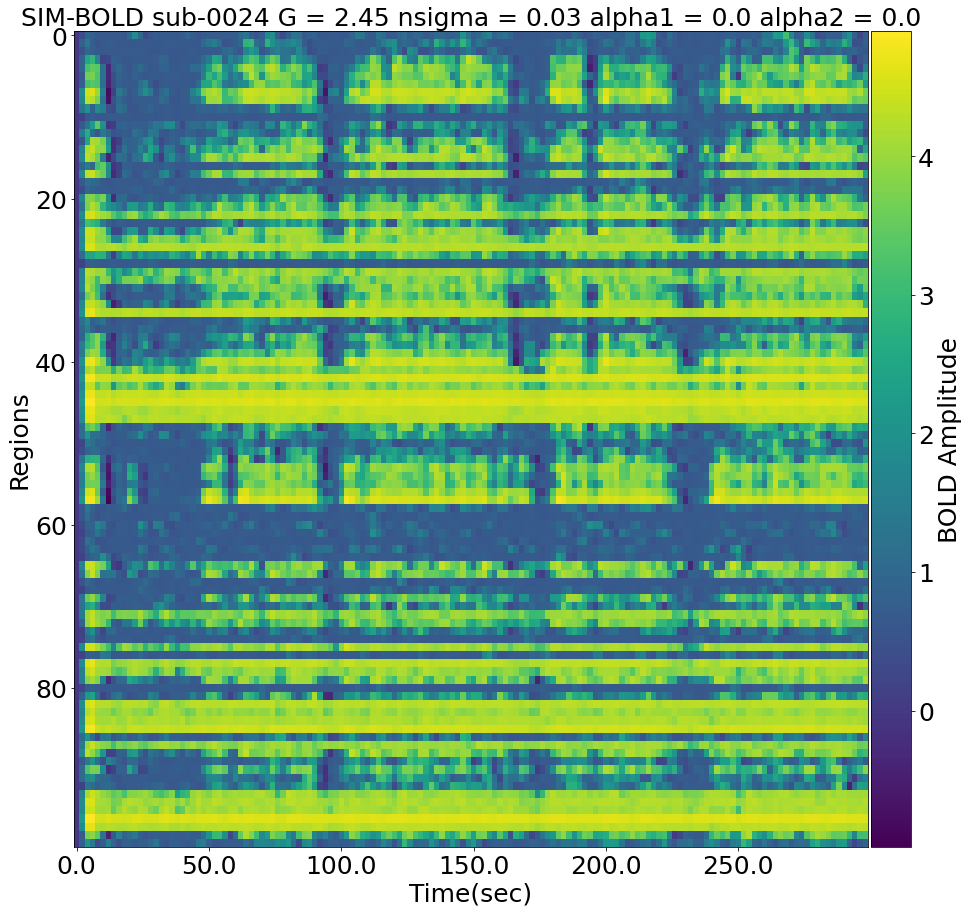

In [13]:
f,ax = plt.subplots(figsize=(15,15))
font_size = 25
bold,time_bold   = collect_bold(G_TAU[G_CHOS],N_TAU[N_CHOS],mysubj,ALPHA1,ALPHA2)
image = ax.imshow(bold.T,aspect='auto')

mytit = separator.join(['SIM-BOLD ',mysubj,' G = ', str(G_TAU[G_CHOS]), 
                        ' nsigma = ', str(N_TAU[N_CHOS]), ' alpha1 = ',str(ALPHA1),' alpha2 = ',str(ALPHA2)])

ax.set_title(mytit,fontsize = font_size)
ax.tick_params(axis="x", labelsize=font_size)  
ax.tick_params(axis="y", labelsize=font_size)
ax.set_xlabel('Time(sec)', fontsize=font_size)
ax.set_ylabel('Regions', fontsize=font_size)

loc   = range(0,bold.shape[0],25)
label = np.array(loc)*2.0
label = label.round(2)

plt.xticks(loc, label);

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax)
cbar.ax.set_ylabel("BOLD Amplitude",fontsize=font_size)
cbar.ax.tick_params(labelsize=font_size)


## 2. The age-trend of the functional changes of 1000BRAINS dataset for the simulated and the empirical data

After determining the couple of parameters $G$ and $\sigma^2$ for 649 subjects, we want to test whether the VAB pipeline could replicate functional changes related to aging and verify that structural changes lead functional changes during senescence. Since we suspected that SC deterioration had the greatest impact on the coactivation between hemispheres [(Mollink et al., 2019](https://www.nature.com/articles/s41593-019-0379-2), [Roland et al., 2017)](https://www.pnas.org/content/114/50/13278) and we also wanted to investigate the impact of SC on brain fluidity [(Courtiol et al., 2020;](https://www.jneurosci.org/content/40/29/5572) [Hansen et al., 2015;](10.1016/j.neuroimage.2014.11.001) [Melozzi et al., 2019)](https://www.pnas.org/content/116/52/26961), the two following summary statistics were computed and benchmarked with the empirical data:

1. The homotopic functional connectivity, which is the average homologous connectivity strength (e.g right and left frontal region) and is defined as:

$$
<Homotopic_{FC}>=\frac{1}{N/2}\sum_{i,j=i+N/2}FC(i,j).
$$

2. The FCD dynamics difference, which is interplay between the full FCD variability and interhemispheric FCD variability and is computed as:

$$ 
\sigma^2_{diff} = ||Upper(FCD)_{interhemispheric-brain}||^2 - ||Upper(FCD)_{full-brain}||^2.
$$

The code blocks below show the comparison of the simulated functional features age-trend with the empirical ones. Each age-trend can be assessed by partial correlation corrected for sex and education between the target statistics and the age variable.

To speed up the process, we can upload the summary statistics saved in a intermediate results file, which are stored in `$MYPATH/aging_virtual_brain/data/interim`.

Intermediate results are also considered personal data, therefore 

### ***Re-read carefully the data alert block***

In [14]:
str_save_feature = separator.join(['interim/julich_100_VAB_features.npz'])

out_feature      = os.path.join(jul.data_root,str_save_feature)

summary_data = np.load(out_feature)


P_LIST        = summary_data["P_LIST"]
myage_list    = summary_data["myage_list"]
mysubj_list   = summary_data["mysubj_list"]
myedu_list    = summary_data["myedu_list"]
mygender_list = summary_data["mygender_list"]

mygenderflag_list    = [float(mygender=='Female') for mygender in mygender_list]

FCD_SUBJ_VAR_OV_TENS = summary_data["FCD_SUBJ_VAR_OV_TENS"]

G_MAX                = summary_data["G_MAX"]
N_MAX                = summary_data["N_MAX"]
FC_CORR_MAX  = summary_data["FC_CORR_MAX"]

FCD_MEAN_OV           = summary_data["FCD_MEAN_OV"]
FCD_VAR_OV            = summary_data["FCD_VAR_OV"]
FCD_DIFF_VAR_OV       = summary_data["FCD_DIFF_VAR_OV"]

HOMO_FC               = summary_data["HOMO_FC"]

FCD_STINTER_GIVEN_FCD = summary_data["FCD_STINTER_GIVEN_FCD"]


HOMO_FC_EMP          = summary_data["HOMO_FC_EMP"]
FCD_INTER_OSC_EMP    = summary_data["FCD_INTER_OSC_EMP"]

FCD_MEAN_OV_EMP      = summary_data["FCD_MEAN_OV_EMP"]
FCD_VAR_OV_EMP       = summary_data["FCD_VAR_OV_EMP"]

FCD_SUBJ_DIFF_VAR_OV_EMP     = summary_data["FCD_SUBJ_DIFF_VAR_OV_EMP"]


In [15]:
from matplotlib import rcParams
#rcParams['figure.figsize'] = 25,20
#fig , ax = plt.subplots(ncols = len(cp_vect1)
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]


In [16]:
fcd_mean_ov  = np.array(FCD_MEAN_OV)
fcd_mean_ov = fcd_mean_ov.reshape(fcd_mean_ov.shape[0],1)

fcd_var_ov   = np.array(FCD_VAR_OV)
fcd_var_ov   = fcd_var_ov.reshape(fcd_var_ov.shape[0],1)

fcd_stack_inter = np.array(FCD_STINTER_GIVEN_FCD)
fcd_stack_inter = fcd_stack_inter.reshape(fcd_stack_inter.shape[0],1)

fcd_mean_ov_emp  = np.array(FCD_MEAN_OV_EMP)
fcd_mean_ov_emp  = fcd_mean_ov_emp.reshape(fcd_mean_ov_emp.shape[0],1)

fcd_var_ov_emp   = np.array(FCD_VAR_OV_EMP)
fcd_var_ov_emp   = fcd_var_ov_emp.reshape(fcd_var_ov_emp.shape[0],1)

fcd_osc_inter_emp   = np.array(FCD_INTER_OSC_EMP)
fcd_osc_inter_emp   = fcd_osc_inter_emp.reshape(fcd_osc_inter_emp.shape[0],1)


fc_corr       = np.array(FC_CORR_MAX)
fc_corr       = fc_corr.reshape(fc_corr.shape[0],1)
gmax_v        = np.array(G_MAX)
gmax_v        = gmax_v.reshape(gmax_v.shape[0],1)
nmax_v        = np.array(N_MAX)
nmax_v        = nmax_v.reshape(nmax_v.shape[0],1)


fcd_subj_diff_var_ov_emp    = np.array(FCD_SUBJ_DIFF_VAR_OV_EMP)
fcd_subj_diff_var_ov_emp    = fcd_subj_diff_var_ov_emp.reshape(fcd_subj_diff_var_ov_emp.shape[0],1)



fcd_diff_var_ov   = np.array(FCD_DIFF_VAR_OV)
fcd_diff_var_ov   = fcd_diff_var_ov.reshape(fcd_diff_var_ov.shape[0],1)

homo_fc           = np.array(HOMO_FC)
homo_fc           = homo_fc.reshape(homo_fc.shape[0],1)
 
homo_fc_emp       = np.array(HOMO_FC_EMP)
homo_fc_emp       = homo_fc_emp.reshape(homo_fc_emp.shape[0],1)


X_list = [fcd_mean_ov,fcd_var_ov,fcd_mean_ov_emp,fcd_var_ov_emp]

X_inter = [fcd_stack_inter,fcd_diff_var_ov,fcd_osc_inter_emp,fcd_subj_diff_var_ov_emp]

X_mean      = [fcd_mean_ov,fcd_var_ov,fcd_mean_ov_emp,fcd_var_ov_emp]

X_fc        = [homo_fc,homo_fc_emp]
X_tune_list = [fc_corr,gmax_v,nmax_v]


X_PLOT  = np.concatenate(X_list,axis=1)
X_TUNE  = np.concatenate(X_tune_list,axis=1)

X_INTER = np.concatenate(X_inter,axis=1)
X_MEAN  = np.concatenate(X_mean,axis=1)

X_FC    = np.concatenate(X_fc,axis=1)


Homotopic FC plot for the empirical dataset

-0.22886185737642842
4.007679862754672e-09


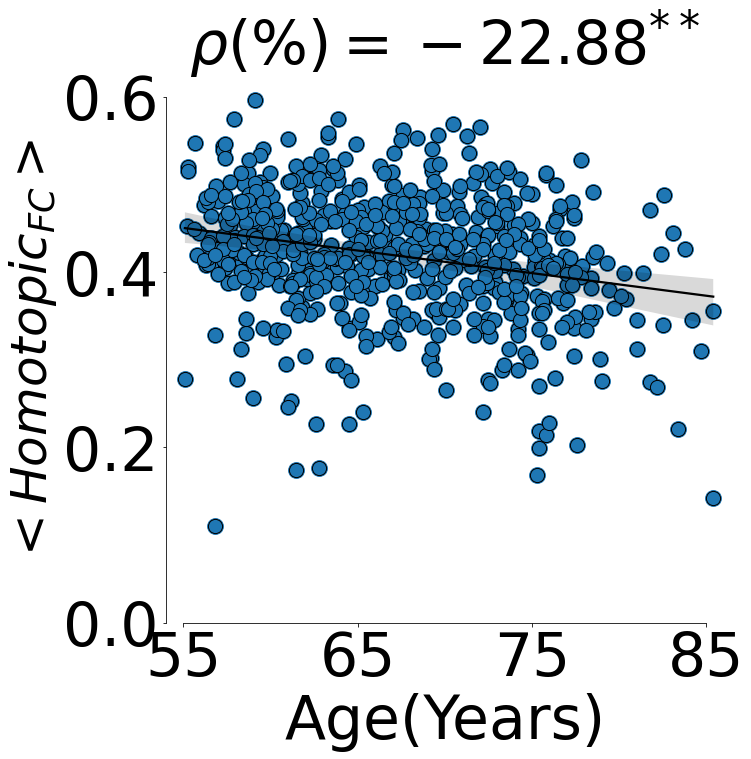

In [17]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 



cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(10,10))

row_idx = 0
col_idx = 0

font_size = 60

feat_list = ['Average Homotopic FC strength','Average Homotopic FC, emp.']


p_idx    = 1

mymat    = X_FC[:,p_idx]

cc_sc        = mymat
age_cc       = myage_list
mygender_cs  = np.array(mygenderflag_list)
myedu_cs     = np.array(myedu_list)

age_cc       = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc        = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]


slope, intercept, r_value, p_value, std_err = stats.linregress(age_cc,cc_sc)
cc_hat = slope*age_cc + intercept
r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

ax.scatter(age_cc, cc_sc,s=250)
# ax.plot(age_cc, cc_hat,linewidth=4)
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200,"alpha":1,"edgecolor":"k"},line_kws={'color':'k'},ax = ax,ci=100)
# ax.set_title(f'{str_yaxis} r(%) ={r_value.round(3)},pv ={p_value.round(3)}',fontsize=font_size);
ax.set_title(r'$\rho(\%) =-22.88^{**}$',fontsize=font_size,x=0.5);
ax.set_xlabel("Age(Years)",fontsize=font_size)
# ax.set_ylabel(str_yaxis,fontsize=font_size-10);
ax.set_ylabel(r"$<Homotopic_{FC}>$",fontsize=font_size-10);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([54,86])

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)


ax.set_xticks([55, 65, 75 ,85])
ax.set_yticks([0.0,0.2,0.4,0.6])
sns.despine(trim=True)

gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

print(r_corr_sex)
print(p_corr_sex)


Homotopic FC plot for the simulated data obtained with empirical connectomes ($SC_{emp}$)

-0.10480923618126414
0.007674276112796694


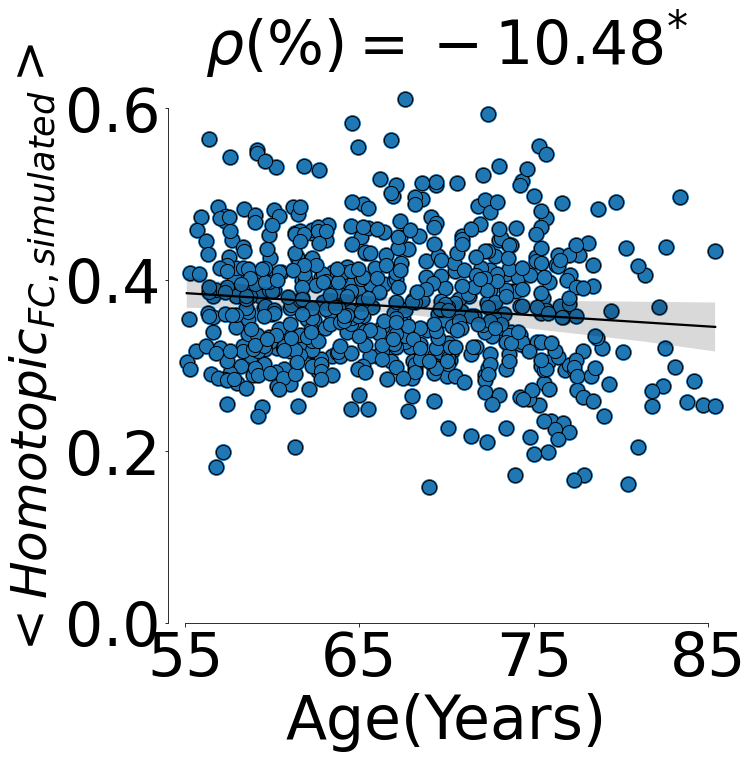

In [18]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 

cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(10,10))

font_size = 60

feat_list = ['Average Homotopic FC strength','Average Homotopic FC strength, empirical']


p_idx     = 0

mymat     = X_FC[:,p_idx]

cc_sc    = mymat
age_cc   = myage_list
mygender_cs  = np.array(mygenderflag_list)
myedu_cs     = np.array(myedu_list)

age_cc       = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc        = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

ax.scatter(age_cc, cc_sc,s=250)
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200,"alpha":1,"edgecolor":"k"},line_kws={'color':'k'},ax = ax,ci=100)
# ax.set_title(r'$\rho(\%) =-10.48$, $p = 0.007$',fontsize=font_size);
ax.set_title(r'$\rho(\%) =-10.48^{*}$',fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(r"$<Homotopic_{FC,simulated}>$",fontsize=font_size-10);
# ax.set_ylabel("",fontsize=font_size-10);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([54,86])

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

ax.set_xticks([55, 65, 75 ,85])
ax.set_yticks([0.0,0.2,0.4,0.6])

sns.despine(trim=True)
    

gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

print(r_corr_sex)
print(p_corr_sex)


FCD variance difference plot for the empirical functional data

-0.2118132682871665
5.6135956591992624e-08


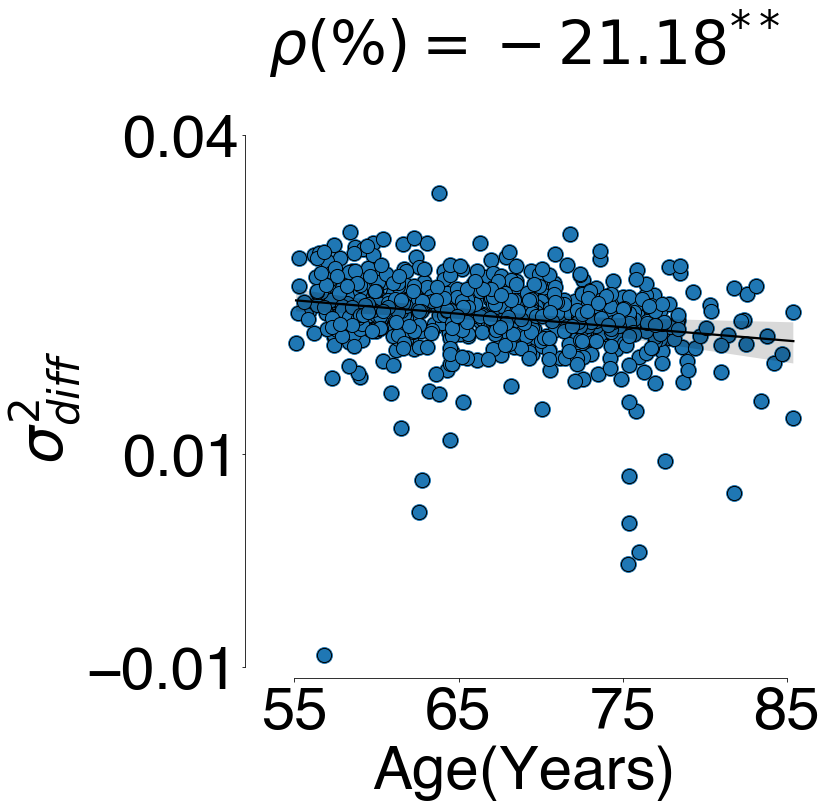

In [19]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 
plt.rcParams.update({'font.family':'helvetica'})


cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(10,10))

row_idx = 0
col_idx = 0

font_size = 60

feat_list = ['STD(Interhemispheric FC STREAM)','VAR(I.FCD) - VAR(F.FCD)','STD(Interhemispheric FC STREAM),empirical',
              'VAR(I.FCD) - VAR(F.FCD), emp.']


p_idx = 3
    
mymat    = X_INTER[:,p_idx]

cc_sc        = mymat
age_cc       = myage_list
mygender_cs  = np.array(mygenderflag_list)
myedu_cs     = np.array(myedu_list)

age_cc       = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc        = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

print(r_corr_sex)
print(p_corr_sex)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

ax.scatter(age_cc, cc_sc,s=250)
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200,"alpha":1,"edgecolor":"k"},line_kws={'color':'k'},ax = ax,ci=100)
# ax.set_title(f'{str_yaxis} r(%) ={r_corr_sex.round(3)},pv ={p_corr_sex.round(3)}',fontsize=font_size);
ax.set_title(r'$\rho(\%) =-21.18^{**}$',fontsize=font_size,x=0.5,y=1.12);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(r'$\sigma^2_{diff}$',fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([52,86])

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

ax.set_xticks([55, 65, 75 ,85])
ax.set_yticks([-0.01, 0.01, 0.04])
sns.despine(trim=True)



FCD variance difference plot for the simulated data obtained with empirical connectomes ($SC_{emp}$)

-0.173969385005968
8.70417568563251e-06


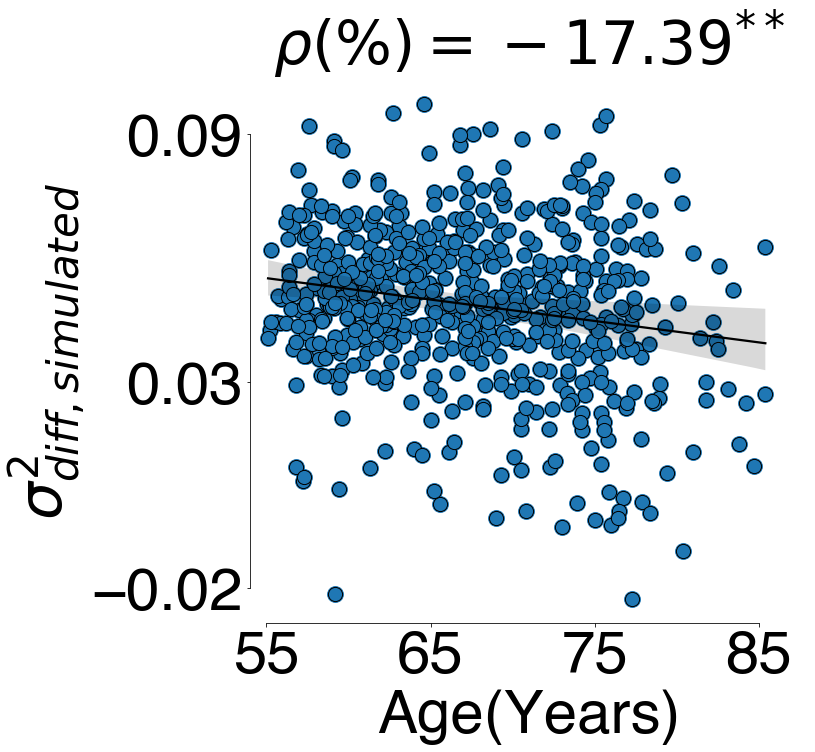

In [20]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 
plt.rcParams.update({'font.family':'helvetica'})


cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(10,10))

font_size = 60

feat_list = ['STD(Interhemispheric FC STREAM)','VAR(I.FCD) - VAR(F.FCD)','STD(Interhemispheric FC STREAM),empirical',
              'VAR(I.FCD) - VAR(F.FCD),empirical']


p_idx = 1
    
mymat    = X_INTER[:,p_idx]


cc_sc    = mymat
age_cc   = myage_list
mygender_cs  = np.array(mygenderflag_list)
myedu_cs     = np.array(myedu_list)

age_cc       = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc        = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

slope, intercept, r_value, p_value, std_err = stats.linregress(age_cc,cc_sc)
cc_hat = slope*age_cc + intercept
r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

ax.scatter(age_cc, cc_sc,s=250)
# ax.plot(age_cc, cc_hat,linewidth=4)
# sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200},line_kws={'color':'k'},ax = ax,ci=100)
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200,"alpha":1,"edgecolor":"k"},line_kws={'color':'k'},ax = ax,ci=100)
# ax.set_title(f'{str_yaxis} r(%) ={r_value.round(3)},pv ={p_value.round(3)}',fontsize=font_size);
# ax.set_title(r'$\rho(\%) =-17.39$, $p \leq 0.001$',fontsize=font_size,y=1.1);
ax.set_title(r'$\rho(\%) =-17.39^{**}$',fontsize=font_size,x=0.5);
ax.set_xlabel("Age(Years)",fontsize=font_size)
# ax.set_xlabel("",fontsize=font_size)
# ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.set_ylabel(r'$\sigma^2_{diff,simulated}$',fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([54,88])
# ax.set_xlim([50,90])

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

locs, labels = plt.xticks()
ax.set_xticks([55, 65, 75 ,85])
# ax.set_xticks([])
ax.set_yticks([-0.02,0.03,0.09])

sns.despine(trim=True)

gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

print(r_corr_sex)
print(p_corr_sex)


## 2. The dynamical variability landscape along age and the trend of $G$ modulation during aging

As anticipated in the notebook `$MYPATH/aging_virtual_brain/notebooks/vab_github_simulation_virtual_aging.ipynb` and the beginning of this notebook, the brain network model presents the parameters $G$ and $\sigma^2$ to be tuned by sweeping the parameters in the range $G = [1.5 - 3.2]$ and the range $\sigma^2 = [0.01-0.05]$. For each subject, we selected the global coupling $G$ and the noise variance $\sigma^2$  by locating the value associated to the maximum $\sigma^2(FCD)$.

Since it multiplies the SC in BNM formulation, the parameter $G$ represents the influence of SC over the brain dynamics and we can consider it as a modulation or a SC-FC tethering index. Based on empirical connectome-based simulations, we can track the trajectory of $\sigma^2_{max}(FCD)$ with age (the so-called brain fludity or dynamical variability landscape) as well as the age-trend of $G$.

By freezing the noise variance ($\sigma^2=0.035$) and ranking the connectome by age, we can plot a $\sigma^2(FCD)$ heatmap along the $Age$ and $G$ dimensions. The result is a landscape or topology of $\sigma^2(FCD)$, where the $\sigma^2_{max}(FCD)$ is highlighted by a red stripe in the plot. Our findings show a shift of the maximum $\sigma^2_{max}(FCD)$ towards the right along $G$ axis for older subjects, which implies a higher $G$ for higher age.

The code blocks below show how to obtain the $G-Age$ heatmap during senescence.

In [21]:
NCHOS = 5  # noise_var = 0.035
SORT_AGE_LIST   = np.argsort(np.array(myage_list))

mymat    = FCD_SUBJ_VAR_OV_TENS[:,NCHOS,SORT_AGE_LIST].T.copy()
age_cc   = np.array(myage_list)[SORT_AGE_LIST]

In [22]:
f,ax     = plt.subplots(figsize=(10,15))
image    = ax.imshow(mymat,aspect='auto',cmap = plt.get_cmap('seismic'))
plt.close()

In [23]:
row_vect = np.where(np.isnan(mymat))[0]
col_vect = np.where(np.isnan(mymat))[1]

for row_idx,col_idx in zip(row_vect,col_vect):
    
    if col_idx < mymat.shape[1]-1:
        mymat[row_idx,col_idx] = (mymat[row_idx,col_idx-1] + mymat[row_idx,col_idx+1])/2
    else:
        mymat[row_idx,col_idx] = mymat[row_idx,col_idx-1] 

In [24]:
age_flip = np.flip(age_cc)
from scipy import interpolate
X, Y = np.meshgrid(G_TAU,age_flip)
Z = mymat

from scipy.ndimage.filters import gaussian_filter
Z3 = gaussian_filter(Z, sigma=1.5)

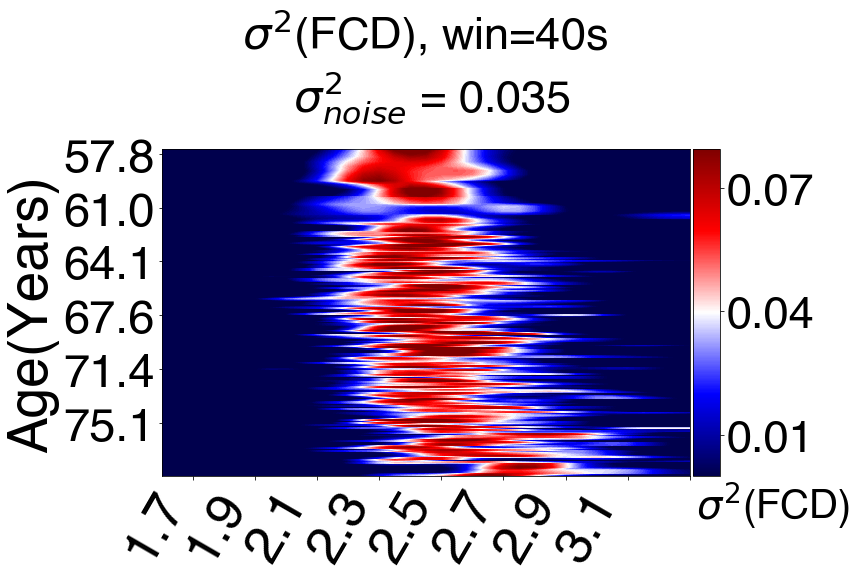

In [25]:
font_size = 45
f,ax     = plt.subplots(figsize=(10,6))
ax.contourf(X, Y, Z3, 100, cmap='seismic',vmax=0.02, vmin=0.005)


loc   = range(0,mymat.shape[1],4)
label = G_VECT.round(7)[loc]
label = label.round(2)

ax.set_xticklabels(label);

plt.xticks(rotation = 60, ha="right",fontsize=font_size+7);

ax.set_yticklabels(age_flip[::100],fontsize=font_size+2);
# plt.xticks([])

ax.set_ylabel("Age(Years)",fontsize=font_size+10,x=3)
# ax.set_xlabel("G - Global Modulation",fontsize=font_size+10)
ax.set_xlabel('',fontsize=font_size+10)

plt.title('$\sigma^2$(FCD), win=40s \n $\sigma^2_{noise}$ = 0.035',fontsize=font_size,y=1.1)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = f.colorbar(image, cax=cax,orientation="vertical",ticks=[0.01,0.04,0.07])
cbar.ax.set_xlabel("$\sigma^2$(FCD)",fontsize=font_size-5,x=3)
cbar.ax.tick_params(labelsize=font_size)


cbar.ax.set_xlabel("$\sigma^2$(FCD)",fontsize=font_size-5,x=3)
cbar.ax.tick_params(labelsize=font_size)

Based on the FCD heatmap, one can clearly monitor how the tuning $G$ changes with age, by selecting the parameter associated to $\sigma^2_{max}(FCD)$ and plotting its trend with age. Code block below shows the plot of G during healthy aging, which has increasing trend (corrected by sex and education).

0.2771594277600751
7.404264548741427e-13


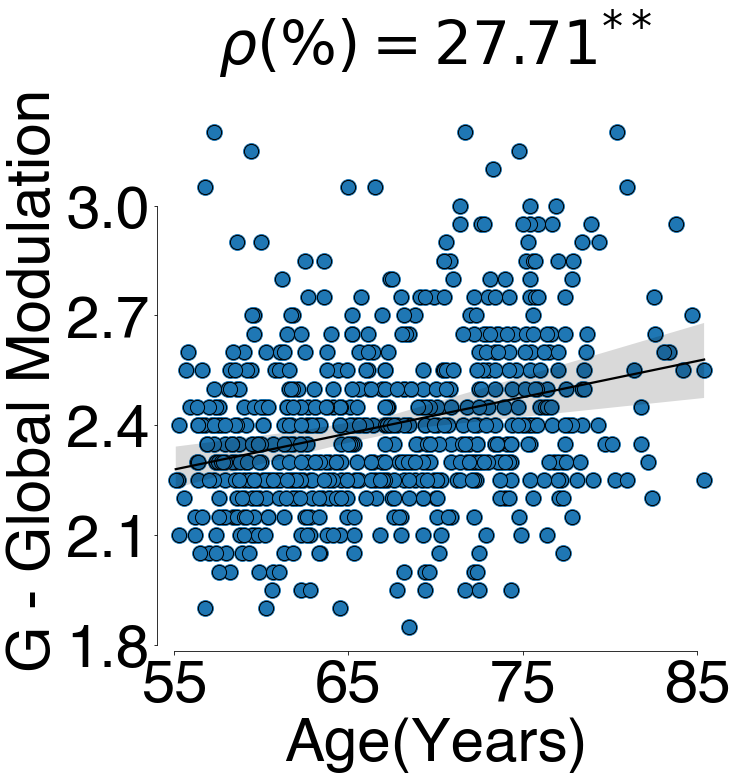

In [26]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 
cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(10,10))
font_size = 60
feat_list = ['FC-FCemp CORR','G - Global Modulation','Noise','SC inter']


p_idx    = 1

mymat    = X_TUNE[:,p_idx]

cc_sc    = mymat
age_cc   = myage_list
mygender_cs  = np.array(mygenderflag_list)
myedu_cs     = np.array(myedu_list)


age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

ax.scatter(age_cc, cc_sc,s=250)
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200,"alpha":1,"edgecolor":"k"},line_kws={'color':'k'},ax = ax,ci=100)
# ax.set_title(f'{str_yaxis} r(%) ={r_value.round(3)},pv ={p_value.round(3)}',fontsize=font_size);
ax.set_title(r'$\rho(\%) =27.71^{**}$',fontsize=font_size,y=1.07);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([54,86])

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)


ax.set_xticks([55, 65, 75 ,85])
ax.set_yticks([1.8,2.1,2.4,2.7,3.0])
sns.despine(trim=True)


gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

print(r_corr_sex)
print(p_corr_sex)


For sake of completeness, one can also track the noise variance $\sigma^2$ of the BNM with age. The code block shows a flat age-trend of the variance, which is centered around $\sigma^2=0.035$.

0.014249132052045496
0.7177403248432527


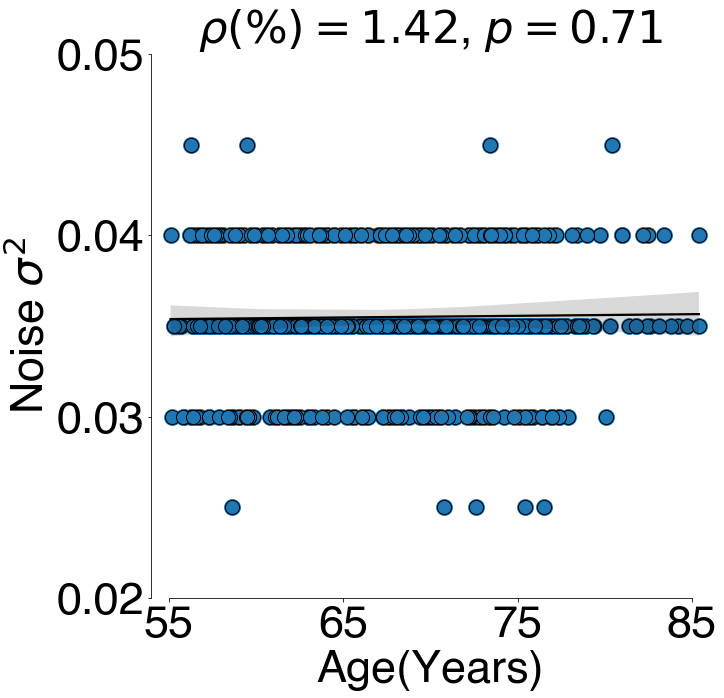

In [27]:
# import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 



cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(10,10))

row_idx = 0
col_idx = 0

font_size = 45
feat_list = ['FC-FCemp CORR','G - Global Modulation','Noise','SC inter']


p_idx    = 2

mymat    = X_TUNE[:,p_idx]

cc_sc    = mymat
age_cc   = myage_list
mygender_cs  = np.array(mygenderflag_list)
myedu_cs     = np.array(myedu_list)


age_cc       = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc        = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

slope, intercept, r_value, p_value, std_err = stats.linregress(age_cc,cc_sc)
cc_hat = slope*age_cc + intercept
r_value = r_value*1e2
data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])
str_yaxis = separator.join([r'Noise $\sigma^2$'])

ax.scatter(age_cc, cc_sc,s=250)
sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200,"alpha":1,"edgecolor":"k"},line_kws={'color':'k'},ax = ax,ci=100)
# ax.set_title(f'{str_yaxis} r(%) ={r_value.round(3)},pv ={p_value.round(3)}',fontsize=font_size);
ax.set_title(r'$\rho(\%) =1.42$, $p = 0.71$',fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([54,86])

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

# ax.text(53,0.005,r'$\mathbf{M}$', fontsize=font_size+20)


ax.set_xticks([55, 65, 75 ,85])
ax.set_yticks([0.02,0.03,0.04,0.05])
sns.despine(trim=True)

row_idx = row_idx + 1

if row_idx > 1:
    row_idx = 0
    col_idx = 1

gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

print(r_corr_sex)
print(p_corr_sex)


## 4. The relationship of the global $G$ with sex and cognitive scores

### Age-trend of G modulation index split by sex 

To sistematically investigate the relationship between structure-function tethering and the progression of cognitive decline [(Reuter-Lorenz et al. 2014)](https://doi.org/10.1007/s11065-014-9270-9), the $G$ modulation index was related to age, sex and cognitive performance.

The following code block shows the trend of G split between men (blue) and women (pink) and the associated partial correlation (corrected for education) of the groups. Subsequently, we show how to compute Fisher's Z based on the correlation values of the two groups.

0.2779016047224977
2.8883587544053734e-07
0.27026863562304915
1.0803410027965055e-06


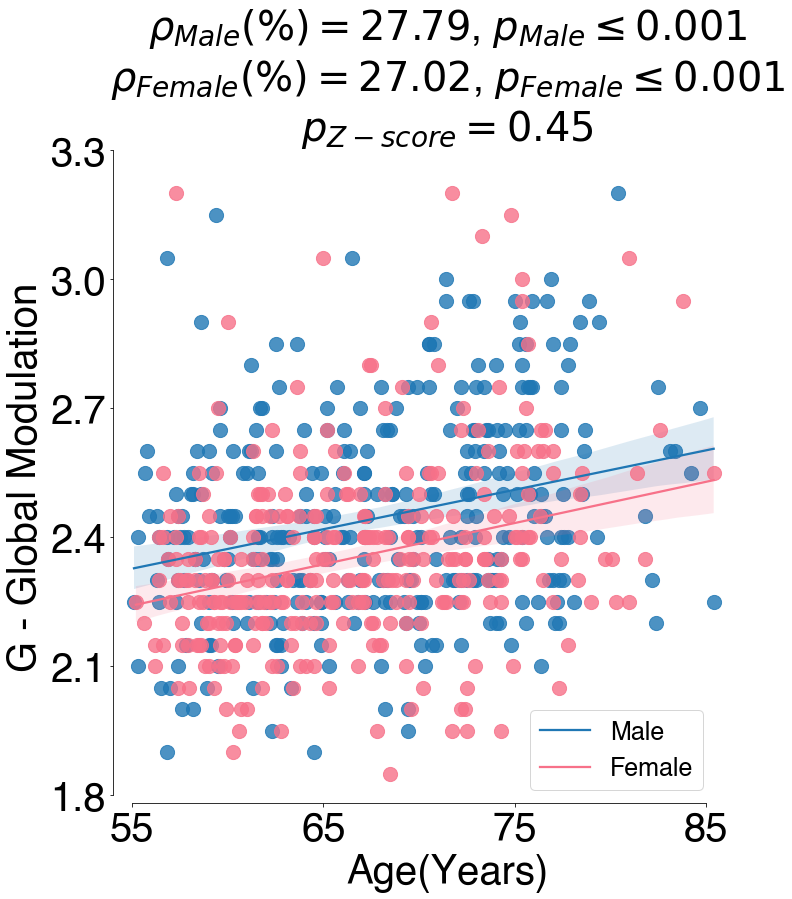

In [28]:
import seaborn as sns
from pingouin import ancova
from pingouin import partial_corr
import pandas as pd
path_root   = os.path.dirname(os.getcwd()) 
cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(12,12))


palette = sns.color_palette("husl", 8)


font_size = 40
feat_list = ['FC-FCemp CORR','G - Global Modulation','Noise','SC inter']


p_idx    = 1

mymat    = X_TUNE[:,p_idx]


cc_sc    = mymat
age_cc   = myage_list

mycs     = mygenderflag_list
myedu_cs = myedu_list


age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mycs     = np.array(mycs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]
cs_thr   = mycs==1


age_cc_1   = age_cc[mycs==0]
cc_sc_1    = cc_sc[mycs==0]
edu_sc_1   = myedu_cs[mycs==0]


age_cc_2   = age_cc[mycs==1]
cc_sc_2    = cc_sc[mycs==1]
edu_sc_2   = myedu_cs[mycs==1]

data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc,
        'cs_thr':cs_thr})

data_reg_1 = pd.DataFrame(
        {'age':age_cc_1,
        'feat_cc':cc_sc_1})

data_reg_2 = pd.DataFrame(
        {'age':age_cc_2,
        'feat_cc':cc_sc_2})


separator = ''
str_yaxis = separator.join(feat_list[p_idx])
mytit     = separator.join([r'$\rho_{Male}(\%) =27.79$, $p_{Male} \leq 0.001$','\n',r'$\rho_{Female}(\%)=27.02$, $p_{Female} \leq 0.001$','\n','$p_{Z-score} = 0.45$'])

sns.regplot(data=data_reg_1, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
sns.regplot(data=data_reg_2, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax,color=palette[0])

ax.set_title(mytit,fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([54,89])
plt.legend(['Male','Female'],fontsize=font_size-15,loc='lower right',bbox_to_anchor=(0.9, 0.0))


plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

ax.set_xticks([55, 65, 75 ,85])
ax.set_yticks([1.8,2.1,2.4,2.7,3.0,3.3])
sns.despine(trim=True)


gender_rep     = mycs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='sex')
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

edu_rep_1        = edu_sc_1
G_POST_RESHAPE_1 = cc_sc_1

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_1,'age':age_cc_1,'edu':edu_sc_1})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='edu')
r_corr_edu = pg["r"][0]
p_corr_edu = pg["p-val"][0]

edu_rep_2        = edu_sc_2
G_POST_RESHAPE_2 = cc_sc_2

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_2,'age':age_cc_2,'edu':edu_sc_2})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='edu')
r_corr_edu_2 = pg["r"][0]
p_corr_edu_2 = pg["p-val"][0]


print(r_corr_edu)
print(p_corr_edu)

print(r_corr_edu_2)
print(p_corr_edu_2)


In [29]:
import scipy.stats as st

rvalue1_z = (np.log(1+r_corr_edu)-np.log(1-r_corr_edu))/2
rvalue2_z = (np.log(1+r_corr_edu_2)-np.log(1-r_corr_edu_2))/2

s_zdiff   = np.sqrt(1/(len(age_cc_1)-3)+1/(len(age_cc_2)-3))
Z_diff    = (rvalue1_z-rvalue2_z)/s_zdiff
p_diff    = 1-st.norm.cdf(Z_diff)
print(rvalue1_z)
print(rvalue2_z)
print(s_zdiff)
print(Z_diff)
print(p_diff)

0.285406614604204
0.2771536043926762
0.07889377068950203
0.10460914897842478
0.4583429773534229


### Ancova test to show age and sex differences for G

The following code block shows how to compute ANCOVA test and check whether there are significant statistical differences between young/old and men/women.

In [30]:
import pandas as pd

sex_rep        = mygenderflag_list
edu_rep        = myedu_list
age_rep        = myage_list
g_rep          = X_TUNE[:,p_idx]

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':myage_list,'sex':gender_rep,'edu':edu_rep})

In [31]:
from pingouin import ancova
ancova_out = ancova(data=df_SC, dv='gcoup', covar=['age','edu'], between='sex',effsize="n2")
print(ancova_out)

     Source         SS   DF          F         p-unc        n2
0       sex   0.969986    1  20.129989  8.569337e-06  0.028047
1       age   2.582138    1  53.586766  7.404265e-13  0.074663
2       edu   0.000092    1   0.001903  9.652188e-01  0.000003
3  Residual  31.031856  644        NaN           NaN       NaN


In [32]:
mypvalue = ancova_out["p-unc"][0]
print(f"{mypvalue:.3f}")

0.000


### Age-trend of G modulation index split by sex and age-group

We plot the same G-trend split by sex for two subgroups: the young population ($age \leq 67$ $years$) and the old population ($age > 67$ $years$), where 67 years is the median threshold. Each plot block is followed by a code block to compute Fisher's Z.

0.08575622115642421
0.2934963402775336
0.10693727655393784
0.16514073640106897


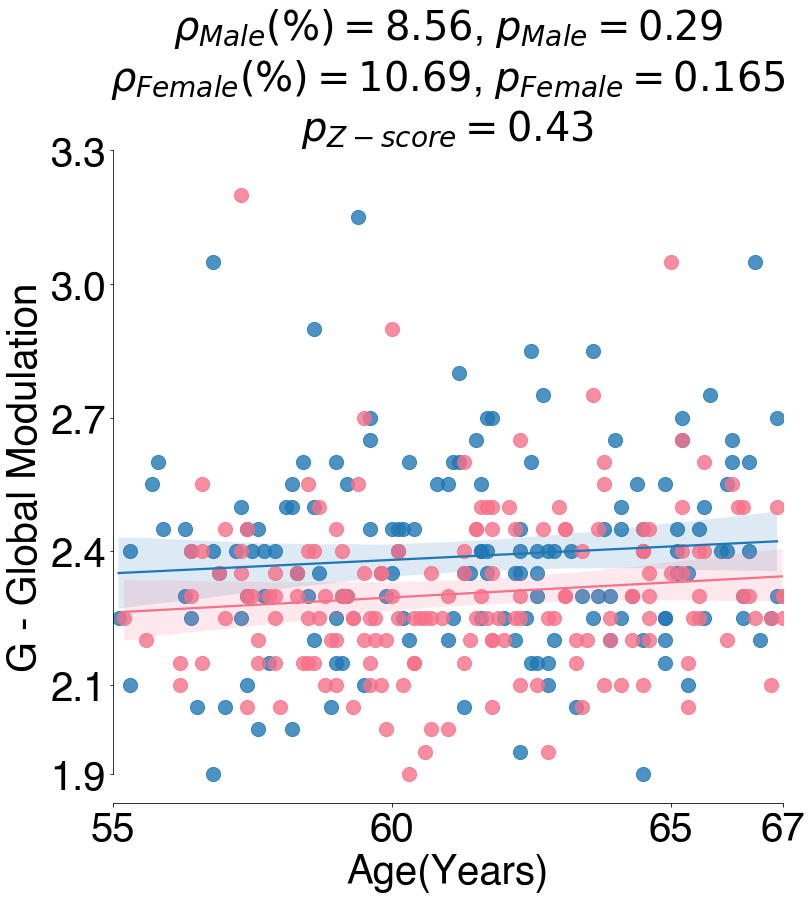

In [33]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 



cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(12,12))

row_idx = 0
col_idx = 0

palette = sns.color_palette("husl", 8)


font_size = 40
feat_list = ['FC-FCemp CORR','G - Global Modulation','Noise','SC inter']


p_idx    = 1

mymat    = X_TUNE[:,p_idx]

cc_sc    = mymat
age_cc   = myage_list

mycs     = mygenderflag_list
myedu_cs = myedu_list


age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mycs     = np.array(mycs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

cs_thr   = mycs==1


AGE_THR = 67

mycs     = np.array(mycs)[age_cc<=AGE_THR]
myedu_cs    = np.array(myedu_cs)[age_cc<=AGE_THR]
cc_sc    = np.array(cc_sc)[age_cc<=AGE_THR]
cs_thr   = np.array(cs_thr)[age_cc<=AGE_THR]
age_cc   = np.array(age_cc)[age_cc<=AGE_THR]


age_cc_1   = age_cc[mycs==0]
cc_sc_1    = cc_sc[mycs==0]
edu_sc_1   = myedu_cs[mycs==0]

age_cc_2   = age_cc[mycs==1]
cc_sc_2    = cc_sc[mycs==1]
edu_sc_2   = myedu_cs[mycs==1]


slope1, intercept1, r_value1, p_value1, std_err = stats.linregress(age_cc_1,cc_sc_1)
cc_hat_1 = slope1*age_cc_1 + intercept1
# r_value1 = r_value1*1e2

slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(age_cc_2,cc_sc_2)
cc_hat_2 = slope2*age_cc_2 + intercept2


data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc,
        'cs_thr':cs_thr})

data_reg_1 = pd.DataFrame(
        {'age':age_cc_1,
        'feat_cc':cc_sc_1})

data_reg_2 = pd.DataFrame(
        {'age':age_cc_2,
        'feat_cc':cc_sc_2})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])
# mytit     = separator.join([r'$\rho_{Male}(\%) =6.34$, $p_{Male} = 0.37$','\n',r'$\rho_{Female}(\%)=11.85$, $p_{Female} = 0.08$'])
mytit     = separator.join([r'$\rho_{Male}(\%) =8.56$, $p_{Male} = 0.29$','\n',r'$\rho_{Female}(\%)=10.69$, $p_{Female} = 0.165$','\n','$p_{Z-score} = 0.43$'])

sns.regplot(data=data_reg_1, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
sns.regplot(data=data_reg_2, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax,color=palette[0])


ax.set_title(mytit,fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
# ax.set_xlim([66,86])
# ax.set_xlim([54,71])
# plt.legend(['Male','Female'],fontsize=font_size,loc='lower right',bbox_to_anchor=(0.9, 0.0))


plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)


ax.set_xticks([55, 60, 65, 67])
ax.set_yticks([1.9,2.1,2.4,2.7,3.0,3.3])
sns.despine(trim=True)

row_idx = row_idx + 1

if row_idx > 1:
    row_idx = 0
    col_idx = 1
    


gender_rep     = mycs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='sex')
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

edu_rep_1        = edu_sc_1
G_POST_RESHAPE_1 = cc_sc_1

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_1,'age':age_cc_1,'edu':edu_sc_1})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='edu')
r_corr_edu = pg["r"][0]
p_corr_edu = pg["p-val"][0]

edu_rep_2        = edu_sc_2
G_POST_RESHAPE_2 = cc_sc_2

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_2,'age':age_cc_2,'edu':edu_sc_2})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='edu')
r_corr_edu_2 = pg["r"][0]
p_corr_edu_2 = pg["p-val"][0]

print(r_corr_edu)
print(p_corr_edu)

print(r_corr_edu_2)
print(p_corr_edu_2)



In [34]:
import scipy.stats as st
rvalue1_z = (np.log(1+r_value1)-np.log(1-r_value1))/2
rvalue2_z = (np.log(1+r_value2)-np.log(1-r_value2))/2
s_zdiff   = np.sqrt(1/(len(age_cc_1)-3)+1/(len(age_cc_2)-3))
Z_diff    = (rvalue2_z-rvalue1_z)/s_zdiff
p_diff    = 1-st.norm.cdf(Z_diff)
print(rvalue1_z)
print(rvalue2_z)
print(s_zdiff)
print(Z_diff)
print(p_diff)

0.08854913965470956
0.10940048155220487
0.11213785047285481
0.18594383439285553
0.4262444033542996


0.2386593188536741
0.0013789826226238016
0.21703117544135947
0.008738653517988615


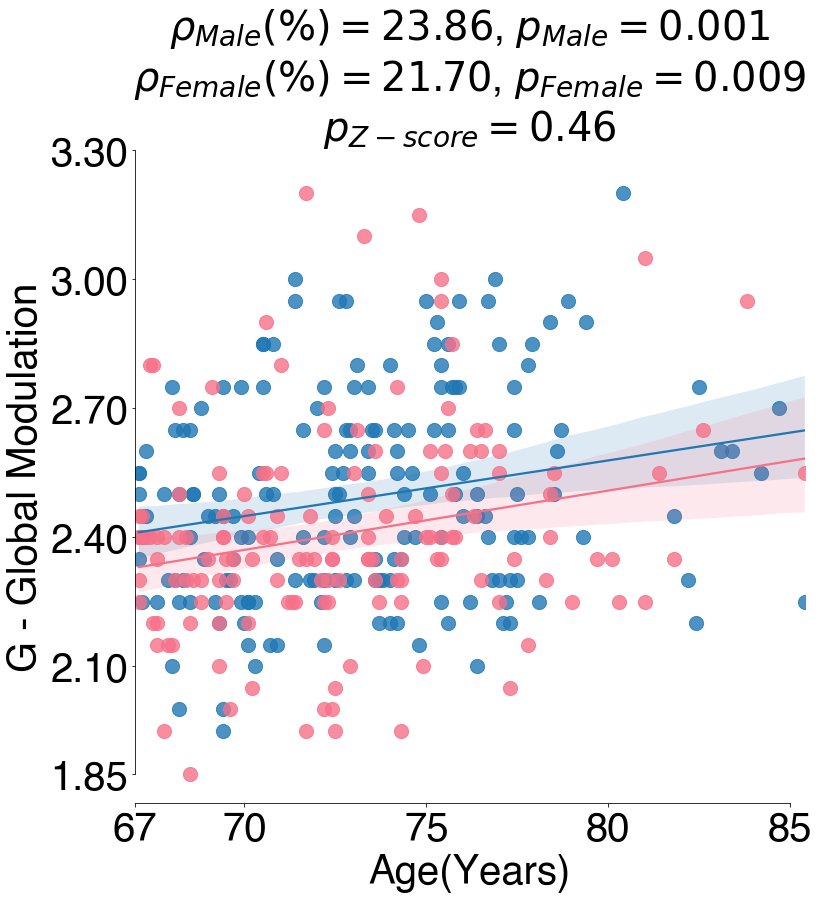

In [35]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 



cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(12,12))

row_idx = 0
col_idx = 0

palette = sns.color_palette("husl", 8)


font_size = 40
feat_list = ['FC-FCemp CORR','G - Global Modulation','Noise','SC inter']


p_idx    = 1

mymat    = X_TUNE[:,p_idx]

cc_sc    = mymat
age_cc   = myage_list

mycs     = mygenderflag_list
myedu_cs = myedu_list


age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mycs     = np.array(mycs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

cs_thr   = mycs==1


AGE_THR = 67

mycs     = np.array(mycs)[age_cc>AGE_THR]
cc_sc    = np.array(cc_sc)[age_cc>AGE_THR]
cs_thr   = np.array(cs_thr)[age_cc>AGE_THR]
myedu_cs    = np.array(myedu_cs)[age_cc>AGE_THR]
age_cc   = np.array(age_cc)[age_cc>AGE_THR]


age_cc_1   = age_cc[mycs==0]
cc_sc_1    = cc_sc[mycs==0]
edu_sc_1   = myedu_cs[mycs==0]

age_cc_2   = age_cc[mycs==1]
cc_sc_2    = cc_sc[mycs==1]
edu_sc_2   = myedu_cs[mycs==1]


slope1, intercept1, r_value1, p_value1, std_err = stats.linregress(age_cc_1,cc_sc_1)
cc_hat_1 = slope1*age_cc_1 + intercept1
# r_value1 = r_value1*1e2

slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(age_cc_2,cc_sc_2)
cc_hat_2 = slope2*age_cc_2 + intercept2
# r_value2 = r_value2*1e2
# data_reg = pd.DataFrame(
#         {'age':age_cc,
#         'feat_cc':cc_sc})

data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc,
        'cs_thr':cs_thr})

data_reg_1 = pd.DataFrame(
        {'age':age_cc_1,
        'feat_cc':cc_sc_1})

data_reg_2 = pd.DataFrame(
        {'age':age_cc_2,
        'feat_cc':cc_sc_2})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

mytit     = separator.join([r'$\rho_{Male}(\%) =23.86$, $p_{Male} = 0.001$','\n',r'$\rho_{Female}(\%)=21.70$, $p_{Female} = 0.009$','\n','$p_{Z-score} = 0.46$'])

sns.regplot(data=data_reg_1, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
sns.regplot(data=data_reg_2, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax,color=palette[0])


ax.set_title(mytit,fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)


plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

ax.set_xticks([67, 70, 75, 80, 85])
ax.set_yticks([1.85,2.1,2.4,2.7,3.0,3.3])
sns.despine(trim=True)


gender_rep     = mycs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='sex')
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

edu_rep_1        = edu_sc_1
G_POST_RESHAPE_1 = cc_sc_1

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_1,'age':age_cc_1,'edu':edu_sc_1})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='edu')
r_corr_edu = pg["r"][0]
p_corr_edu = pg["p-val"][0]

edu_rep_2        = edu_sc_2
G_POST_RESHAPE_2 = cc_sc_2

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_2,'age':age_cc_2,'edu':edu_sc_2})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar='edu')
r_corr_edu_2 = pg["r"][0]
p_corr_edu_2 = pg["p-val"][0]


print(r_corr_edu)
print(p_corr_edu)

print(r_corr_edu_2)
print(p_corr_edu_2)



In [36]:
import scipy.stats as st
rvalue1_z = (np.log(1+r_value1)-np.log(1-r_value1))/2
rvalue2_z = (np.log(1+r_value2)-np.log(1-r_value2))/2
s_zdiff   = np.sqrt(1/(len(age_cc_1)-3)+1/(len(age_cc_2)-3))
Z_diff    = (rvalue2_z-rvalue1_z)/s_zdiff
p_diff    = 1-st.norm.cdf(Z_diff)
print(rvalue1_z)
print(rvalue2_z)
print(s_zdiff)
print(Z_diff)
print(p_diff)

0.22100143513047676
0.23293028381306524
0.11272662820865666
0.10582103689385806
0.4578621727384402


### Relationship between G modulation index and cognitive scores

In order to assess whether the variabiliy of SC-FC tethering is capable to explain the variability of cognitive decline, we tested the relationship between cogntive scores and the indipendent variables $G$, $age$, $sex$ and $education$ via an ordinary least-squares regression.

The VAB pipeline is a model-driven exploration of cognitive decline. To assess the effect on cognition, the following codeblocks upload the cognitive scores, which are located in `$MYPATH/aging_virtual_brain/data/external`. Since the cognitive scores are personal data, we invite the user once again to

### ***Re-read carefully the data alert block***

In [37]:
d              = os.path.join(jul.ds_external)
separator      = ''
score_frame    = pd.read_csv(separator.join([d,'/1000BD_cognitivescore_1visit.csv']),delimiter=";",decimal = ',')
score_frame.columns

Index(['ID', 'Visit', 'Age', 'Sex', 'ISCED_97', 'LPS_RRW(ProblemSolving)',
       'AKT_TRW(SelectiveAttention)', 'Stroop_T3T2(Interference)',
       'RWD_5_Punkte(FiguralFluency)', 'TMT_ARW(ProcessingSpeed)',
       'TMT_BA(ConceptShifting)', 'BEN_RRW(FiguralMemory)',
       'CBT_RVW(VisualSpatialWM_fw)', 'CBT_RRW_(VisualSpatialWM_bw)',
       'VPT_RW(VisualMemory)', 'ZNS_AVW(digitspan_fw)',
       'ZNS_ARW(digitspan_bw)', 'BNT_RT', 'RWT_PB2RW(PhonematicFluency)',
       'RWT_SB2RW(SemanticFluency)', 'RWT_PGR2RW(PhonematicFluency_Switch)',
       'RWT_SSF2RW(SemanticFluency_Switch)', 'AWST03P(Vocabulary)',
       'DemTect_Gesamt', 'BKW_1_5(VerbalMemory)', 'Unnamed: 25',
       'Unnamed: 26'],
      dtype='object')

In [38]:
subj_age_CS         = score_frame["Age"]
gender_CS           = score_frame["Sex"].tolist()
subj_ID_CS          = score_frame["ID"].tolist()
visit_CS            = score_frame["Visit"].tolist()
education_CS        = score_frame["ISCED_97"]

gender_list_cs      = [int(gender_loc=='Female') for gender_loc in gender_CS]

problem_solving     = score_frame["LPS_RRW(ProblemSolving)"]
selectiveattention  = score_frame["AKT_TRW(SelectiveAttention)"]
  
interference        = score_frame["Stroop_T3T2(Interference)"]


figurefluency       = score_frame["RWD_5_Punkte(FiguralFluency)"]

processing_speed    = score_frame["TMT_ARW(ProcessingSpeed)"]
concept_shifting    = score_frame["TMT_BA(ConceptShifting)"]
figuralmemory       = score_frame["BEN_RRW(FiguralMemory)"]

visualspat_fw       = score_frame["CBT_RVW(VisualSpatialWM_fw)"]
visualspat_bw       = score_frame["CBT_RRW_(VisualSpatialWM_bw)"]

visualmem           = score_frame["VPT_RW(VisualMemory)"]

digitspan_bw        = score_frame["ZNS_ARW(digitspan_bw)"]
digitspan_fw        = score_frame["ZNS_AVW(digitspan_fw)"]

selectiveattention  = score_frame["AKT_TRW(SelectiveAttention)"]
figuralmemory       = score_frame["BEN_RRW(FiguralMemory)"]

verbalmemory        = score_frame["BKW_1_5(VerbalMemory)"]


bnt_rt              = score_frame["BNT_RT"]


PhonematicFluency   = score_frame["RWT_PB2RW(PhonematicFluency)"]
SemanticFluency     = score_frame["RWT_SB2RW(SemanticFluency)"]
PhonematicFluency_Switch  = score_frame["RWT_PGR2RW(PhonematicFluency_Switch)"]
SemanticFluency_Switch    = score_frame["RWT_SSF2RW(SemanticFluency_Switch)"]
Vocabulary          = score_frame["AWST03P(Vocabulary)"]


Dementia            = score_frame["DemTect_Gesamt"]

In [39]:
# loc_plist_cs  = [loc_subj for loc_subj in range(len(subj_ID_CS)) if np.sum(subj_ID_CS[loc_subj]==np.array(P_LIST))]
loc_plist_cs =[]
for pidx in range(len(P_LIST)):
    loc_plist_cs_entry = [loc_subj for loc_subj in range(len(subj_ID_CS)) if P_LIST[pidx] in subj_ID_CS[loc_subj]][0]
    loc_plist_cs +=[loc_plist_cs_entry]

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import families

p_idx    = 1
mymat    = X_TUNE[:,p_idx]

After we create a dataframe with all the cognitive scores (where the concept-shifting, the processing speed and the interference scores are changed in sign to have a negative trend with age), we computed an OLS model for each score as follows:

$Cognitive$ $Score \sim \beta_0 + \beta_{age} age + \beta_G G + \beta_{sex} sex + \beta_{edu} edu$

where $\beta_i$ is the coefficient for the specific independent variable and $\beta_0$ is the intercept. For each model, we also computed the coefficient $R^2$, the F-statistics ($F$) and the associated p-value. Moreover, we applied Bonferroni correction to all p-values of the OLS coefficient by multplying with the total number of scores (16). 

The output of OLS is preceded by a table with median and the 25th/75th percentile of the cognitive scores of the 10000BRAINS. Eventually, the OLS output has been sorted by the p-value associated with the network modulation $G$.

In [41]:
feature_cs_list = ['visualspat_fw','visualspat_bw','visualmem','figuralfluency',
                  'problem_solving','interference','concept_shifting','digitspan_bw','digitspan_fw',
                  'vocabulary','phonematic_fluency','semantic_fluency','verbalmemory','figuralmemory',
                  'processing_speed','selectiveattention'
                  ]


x_df = pd.DataFrame({'G_coup':mymat,
                     'age':subj_age_CS[loc_plist_cs],
                     'semantic_fluency':SemanticFluency[loc_plist_cs],
                     'concept_shifting':concept_shifting[loc_plist_cs]*(-1),
                     'processing_speed':processing_speed[loc_plist_cs]*(-1),
                     'edu':education_CS[loc_plist_cs],
                     'phonematic_fluency':PhonematicFluency[loc_plist_cs],
                     'phonema_switch':PhonematicFluency_Switch[loc_plist_cs],
                     'sem_switch':SemanticFluency_Switch[loc_plist_cs],
                     'problem_solving':problem_solving[loc_plist_cs],
                     'vocabulary':Vocabulary[loc_plist_cs],
                     'dementia':Dementia[loc_plist_cs]*(-1),
                     'selectiveattention':selectiveattention[loc_plist_cs],
                     'interference':interference[loc_plist_cs]*(-1),
                     'figuralfluency':figurefluency[loc_plist_cs],
                     'visualspat_fw':visualspat_fw[loc_plist_cs],
                     'visualspat_bw':visualspat_bw[loc_plist_cs],
                     'visualmem':visualmem[loc_plist_cs],
                     'digitspan_bw':digitspan_bw[loc_plist_cs],
                     'digitspan_fw':digitspan_fw[loc_plist_cs],
                     'figuralmemory':figuralmemory[loc_plist_cs],
                     'verbalmemory':verbalmemory[loc_plist_cs],
                     'sex':np.array(gender_list_cs)[loc_plist_cs],
                     'edu':education_CS[loc_plist_cs]},
                     )

X_OLS   = np.empty([len(feature_cs_list)*2,9])
X_OLS[:] = np.nan


for cs_idx in range(len(feature_cs_list)):
    
    score_cs_str = feature_cs_list[cs_idx]
    formula      = separator.join([score_cs_str,'~age+G_coup+sex+edu'])
    lm           = ols(formula, x_df).fit()
    
    X_OLS[2*cs_idx,0] = lm.params['Intercept']
    X_OLS[2*cs_idx,1] = lm.params['age']
    X_OLS[2*cs_idx,2] = lm.params['G_coup']
    X_OLS[2*cs_idx,3] = lm.params['sex']
    X_OLS[2*cs_idx,4] = lm.params['edu']
    X_OLS[2*cs_idx,5] = lm.rsquared
    X_OLS[2*cs_idx,6] = lm.f_pvalue
    X_OLS[2*cs_idx,7] = lm.fvalue
    X_OLS[2*cs_idx,8] = lm.pvalues['G_coup']*len(feature_cs_list) - 1e-10
    
    X_OLS[2*cs_idx+1,0]   = lm.pvalues['Intercept']*len(feature_cs_list)
    X_OLS[2*cs_idx+1,1]   = lm.pvalues['age']*len(feature_cs_list)
    X_OLS[2*cs_idx+1,2]   = lm.pvalues['G_coup']*len(feature_cs_list)
    X_OLS[2*cs_idx+1,3]   = lm.pvalues['sex']*len(feature_cs_list)
    X_OLS[2*cs_idx+1,4]   = lm.pvalues['edu']

    X_OLS[2*cs_idx+1,8]   = lm.pvalues['G_coup']*len(feature_cs_list)
    
    
X_TAB    = np.empty([len(feature_cs_list),5])
X_TAB[:] = np.nan


for cs_idx in range(len(feature_cs_list)):
    
    score_cs_str = feature_cs_list[cs_idx]
    myfeat       = x_df[score_cs_str]
    
    X_TAB[cs_idx,0] = np.nanquantile(myfeat, 0.5)
    X_TAB[cs_idx,1] = np.nanquantile(myfeat, 0.25)
    X_TAB[cs_idx,2] = np.nanquantile(myfeat, 0.75)
    X_TAB[cs_idx,3] = np.nanmean(myfeat)
    X_TAB[cs_idx,4] = np.nanstd(myfeat)
    

In [42]:
df_tab_result    = pd.DataFrame(data=X_TAB, index=np.array(feature_cs_list), columns=["Median","q25","q75","mean","std"])

In [43]:
df_tab_result

,Median,q25,q75,mean,std
visualspat_fw,5.000,5.000,6.0000,5.403698,0.930754
visualspat_bw,5.000,4.000,5.0000,4.691358,1.049891
visualmem,8.000,6.000,9.0000,7.782071,1.805141
figuralfluency,26.000,21.000,31.0000,26.288580,7.655894
problem_solving,21.000,17.000,24.0000,20.705148,5.135796
interference,-38.420,-49.885,-30.0550,-43.675750,25.079774
concept_shifting,-45.235,-66.790,-30.0975,-54.820248,39.686313
digitspan_bw,4.000,4.000,5.0000,4.704050,1.100672
digitspan_fw,6.000,5.000,7.0000,6.082043,1.067861
vocabulary,31.000,28.000,34.0000,30.918367,4.696730


In [44]:
feature_tex_list = ['visualspat_fw','','visualspat_bw','','visualmem','','figuralfluency','',
                  'problem_solving','','interference','','concept_shifting','','digitspan_bw','','digitspan_fw','',
                  'vocabulary','','phonematic_fluency','','semantic_fluency','','verbalmemory','','figuralmemory','',
                  'processing_speed','','selectiveattention',''
                  ]

pval_g          = X_OLS[:,8]
loc_pval        = np.argsort(pval_g)
df_ols_result   = pd.DataFrame(data=X_OLS[loc_pval,:8], index=np.array(feature_tex_list)[loc_pval], columns=["Intercept","age","G_coup","sex","edu","R","pF","F"])

The output of the OLS shows that both concept shifting and the verbal memory are negatively correlated with the modulation $G$ index. 

In [45]:
df_ols_result

,Intercept,age,G_coup,sex,edu,R,pF,F
concept_shifting,6.959755e+01,-1.540461e+00,-19.940297,3.072848e+00,3.928791e+00,0.152489,5.946656e-22,28.698090
,1.023125e-02,2.413090e-10,0.043372,5.071795e+00,6.067946e-07,NaN,NaN,NaN
verbalmemory,7.455224e+01,-4.565133e-01,-4.946620,6.376161e+00,1.112051e+00,0.261765,4.609684e-40,55.492074
,1.279462e-41,3.001628e-14,0.044499,6.896286e-15,1.609194e-08,NaN,NaN,NaN
problem_solving,3.348873e+01,-2.053740e-01,-1.856166,-1.883239e-01,8.541261e-01,0.220266,3.497842e-33,44.845165
,1.227104e-34,8.240596e-12,0.388902,9.944449e+00,1.238686e-17,NaN,NaN,NaN
vocabulary,2.947960e+01,-4.242063e-02,-1.404876,1.839634e-01,1.171420e+00,0.249032,4.563060e-38,52.312294
,6.581337e-33,1.479869e+00,0.932382,9.487496e+00,3.468688e-36,NaN,NaN,NaN
interference,1.449096e+01,-8.429248e-01,-7.653494,3.094422e+00,2.354082e+00,0.112798,1.225980e-15,20.151526
,4.312883e+00,1.484668e-07,1.193195,1.920170e+00,3.866803e-06,NaN,NaN,NaN


### Age-trend of G modulation index split by concept-shifting

Based on the results of the OLS analysis, we decided to investigate the age-trend of $G$ split by two groups of high and low cognitive perfomers via the median concept shifiting as threshold.

The following code block plots the age-trend of G for low performers (blue) and high performer (orange) and the associated correlation values. The subsequent code block computes the associated Fisher's Z. 

Our findings show that the low performers present higher G values and a steeper increase with healthy aging than high performers. This may suggest a recalibration strategy associated to a scaffolding effect [(Reuter-Lorenz et al. 2014)](https://doi.org/10.1007/s11065-014-9270-9), which does not occur in high performers for other intervening factors (see STAC theory for details).

The fisher's Z confirms the two different trends for the two groups.

r_b(%) =0.314
pv_b =9e-09
r_o.ge(%) =0.1896
pv2_o.ge =0.000664


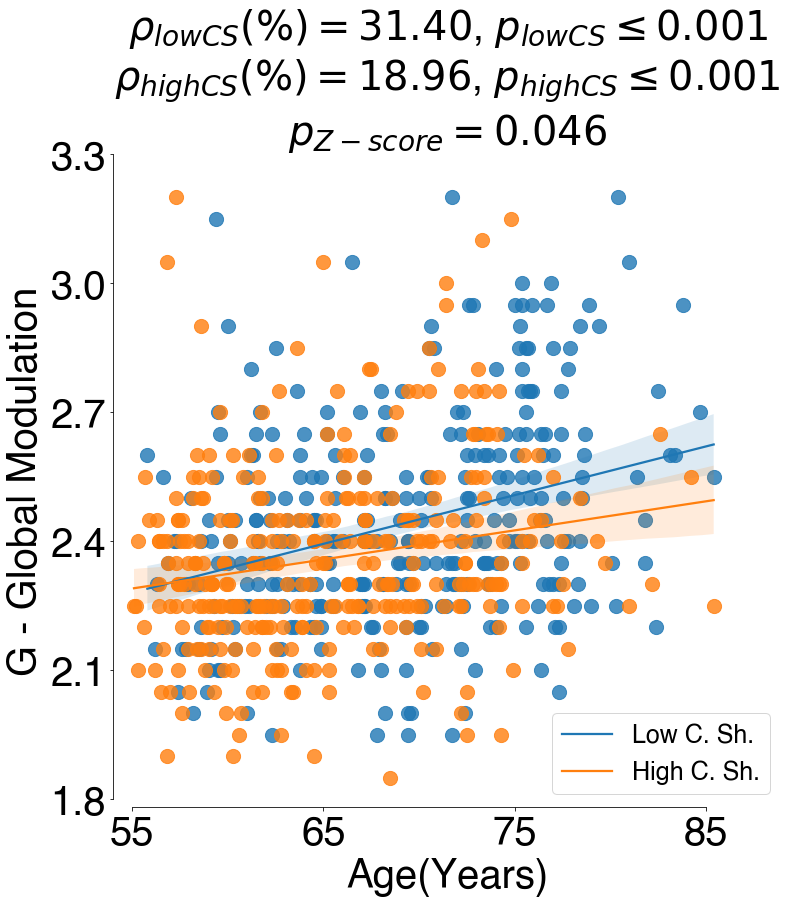

In [46]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 



cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(12,12))

row_idx = 0
col_idx = 0

font_size = 40
feat_list = ['FC-FCemp CORR','G - Global Modulation','Noise','SC inter']


p_idx    = 1

mymat    = X_TUNE[:,p_idx]


cc_sc    = mymat
age_cc   = myage_list
# mycs     = list(processing_speed[loc_plist_cs])
mycs         = list(concept_shifting[loc_plist_cs]*(-1))
mygender_cs  = np.array(gender_list_cs)[loc_plist_cs]
myedu_cs     = np.array(education_CS[loc_plist_cs])
# mycs     = list(SemanticFluency[loc_plist_cs])
# age_cc    = list(subj_age_CS[loc_plist_cs])

age_cc       = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs  = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs     = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
mycs         = np.array(mycs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc        = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

cs_thr       = mycs>np.nanmedian(mycs)


age_cc_1   = age_cc[mycs<=np.nanmedian(mycs)]
cc_sc_1    = cc_sc[mycs<=np.nanmedian(mycs)]
mycs_1     = mycs[mycs<=np.nanmedian(mycs)]


age_cc_2   = age_cc[mycs>np.nanmedian(mycs)]
cc_sc_2    = cc_sc[mycs>np.nanmedian(mycs)]
mycs_2     = mycs[mycs>np.nanmedian(mycs)]


edu_sc_1   = myedu_cs[mycs<=np.nanmedian(mycs)]
edu_sc_2   = myedu_cs[mycs>np.nanmedian(mycs)]

sex_sc_1   = mygender_cs[mycs<=np.nanmedian(mycs)]
sex_sc_2   = mygender_cs[mycs>np.nanmedian(mycs)]


data_reg_1 = pd.DataFrame(
        {'age':age_cc_1,
        'feat_cc':cc_sc_1,
        'cs_thr':mycs_1})

data_reg_2 = pd.DataFrame(
        {'age':age_cc_2,
        'feat_cc':cc_sc_2,
        'cs_thr':mycs_2})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])



mytit     = separator.join([r'$\rho_{low CS}(\%) =31.40$, $p_{low CS} \leq 0.001$','\n',r'$\rho_{high CS}(\%)=18.96$, $p_{high CS} \leq 0.001$','\n','$p_{Z-score} = 0.046$'])

sns.regplot(data=data_reg_1, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
sns.regplot(data=data_reg_2, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
#     sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200},ax = ax[row_idx,col_idx],ci=None)
# ax.set_title(f'r_b(%) ={r_value1.round(3)},pv_b ={p_value1.round(3)},r_o.ge(%) ={r_value2.round(3)},pv2_o.ge ={p_value2.round(3)}',fontsize=font_size);
ax.set_title([r'$\rho_{low CS}(\%) =31.40$, $p_{low CS} \leq 0.001$','\n',r'$\rho_{high CS}(\%)=19.96$, $p_{high CS} \leq 0.001$','\n','$p_{Z-score} = 0.046$'],fontsize=font_size);

ax.set_title(mytit,fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xlim([54,89])
plt.legend(['Low C. Sh.','High C. Sh.'],fontsize=font_size-15,loc='lower right',bbox_to_anchor=(1.0, 0.0))

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)

ax.set_xticks([55, 65, 75 ,85])
ax.set_yticks([1.8,2.1,2.4,2.7,3.0,3.3])
sns.despine(trim=True)

row_idx = row_idx + 1

if row_idx > 1:
    row_idx = 0
    col_idx = 1
    
csh_rep        = mycs>np.nanmedian(mycs)
gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'csh':csh_rep ,'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]




edu_rep_1        = edu_sc_1
G_POST_RESHAPE_1 = cc_sc_1

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_1,'age':age_cc_1,'edu':edu_sc_1,'sex':sex_sc_1})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_edu = pg["r"][0]
p_corr_edu = pg["p-val"][0]

edu_rep_2        = edu_sc_2
G_POST_RESHAPE_2 = cc_sc_2

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_2,'age':age_cc_2,'edu':edu_sc_2,'sex':sex_sc_2})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_edu_2 = pg["r"][0]
p_corr_edu_2 = pg["p-val"][0]

print(f'r_b(%) ={r_corr_edu.round(4)}')
print(f'pv_b ={p_corr_edu.round(9)}')

print(f'r_o.ge(%) ={r_corr_edu_2.round(4)}')
print(f'pv2_o.ge ={p_corr_edu_2.round(6)}')



In [47]:
import scipy.stats as st

rvalue1_z = (np.log(1+r_corr_edu)-np.log(1-r_corr_edu))/2
rvalue2_z = (np.log(1+r_corr_edu_2)-np.log(1-r_corr_edu_2))/2
s_zdiff   = np.sqrt(1/(len(age_cc_1)-3)+1/(len(age_cc_2)-3))
Z_diff    = (rvalue1_z-rvalue2_z)/s_zdiff


p_diff    = 1-st.norm.cdf(Z_diff)
print(rvalue1_z)
print(rvalue2_z)
print(s_zdiff)
print(Z_diff)
print(p_diff)

0.3249694674645274
0.19191235036902943
0.07918075824648958
1.6804223657633
0.046437583739298405


### Ancova test to show age and sex differences for G

The following code block shows how to compute ANCOVA test and check whether there are significant statistical differences between low performers/high performers.

In [48]:
import pandas as pd
csh_rep     = mycs>np.nanmedian(mycs)
gender_rep  = mygender_cs
edu_rep     = myedu_cs
G_POST_RESHAPE = cc_sc
df_SC    = pd.DataFrame({'csh':csh_rep ,'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})

In [49]:
from pingouin import ancova
ancova_out = ancova(data=df_SC, dv='gcoup', covar=['age', 'sex', 'edu'], between='csh',effsize="n2")
print(ancova_out)

     Source         SS   DF          F         p-unc        n2
0       csh   0.263242    1   5.501204  1.930637e-02  0.007748
1       age   2.064695    1  43.147819  1.048150e-10  0.060774
2       sex   0.870159    1  18.184519  2.306023e-05  0.025613
3       edu   0.006657    1   0.139123  7.092777e-01  0.000196
4  Residual  30.768614  643        NaN           NaN       NaN


In [50]:
ancova_out["p-unc"][0]

0.01930637310146726

### Age-trend of G modulation index split by concept shifting and age-group

Similarly to the sex variable, we plot the same G-trend split by concept shifting for two subgroups: the young population ($age \leq 67$ $years$) and the old population ($age > 67$ $years$), where 67 years is the median threshold. Each plot block is followed by a code block to compute Fisher's Z.

We obtained a more prominent increase for lowe perfomers in the old population, while the youngest subjects do not show a G-trend difference in terms of cognitive performance.

r_b(%) =0.1249
pv_b =0.115420869
r_o.ge(%) =0.0548
pv2_o.ge =0.494128


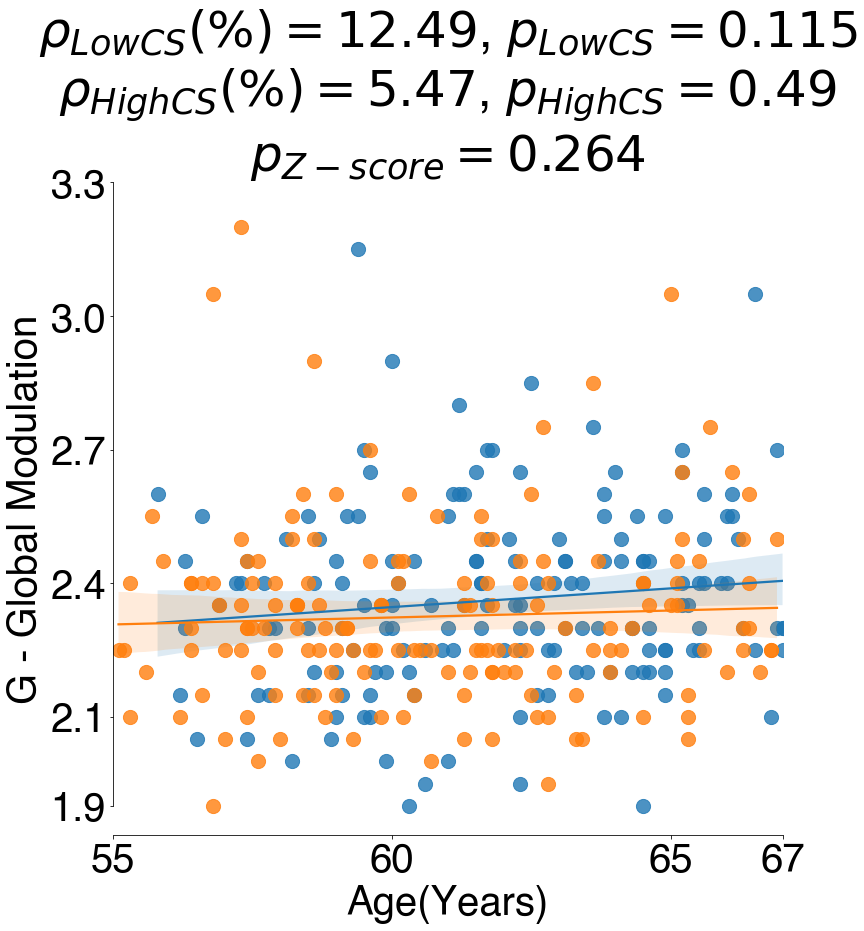

In [51]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 

cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(12,12))

row_idx = 0
col_idx = 0

palette = sns.color_palette("husl", 8)


font_size = 40
feat_list = ['FC-FCemp CORR','G - Global Modulation','Noise','SC inter']


p_idx    = 1

mymat    = X_TUNE[:,p_idx]

# mymat    = np.array(FCD_SUBJ_DIFF_VAR_EMP)

# mymat    = np.array(FCD_DIFF_VAR_FCD)

# mymat    = np.array(HOMO_FC)

cc_sc    = mymat
age_cc   = myage_list
# mycs     = list(verbalmemory[loc_plist_cs])
mycs     = list(concept_shifting[loc_plist_cs]*(-1))
mygender_cs  = np.array(gender_list_cs)[loc_plist_cs]
myedu_cs     = np.array(education_CS[loc_plist_cs])
# age_cc    = list(subj_age_CS[loc_plist_cs])

age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs     = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
mycs     = np.array(mycs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

cs_thr   = mycs>np.nanmedian(mycs)

AGE_THR = 67

mycs     = np.array(mycs)[age_cc<=AGE_THR]
mygender_cs  = np.array(mygender_cs)[age_cc<=AGE_THR]
myedu_cs     = np.array(myedu_cs)[age_cc<=AGE_THR]
cc_sc    = np.array(cc_sc)[age_cc<=AGE_THR]
cs_thr   = np.array(cs_thr)[age_cc<=AGE_THR]
age_cc   = np.array(age_cc)[age_cc<=AGE_THR]


age_cc_2   = age_cc[mycs>np.nanmedian(mycs)]
cc_sc_2    = cc_sc[mycs>np.nanmedian(mycs)]
mycs_2     = mycs[mycs>np.nanmedian(mycs)]


age_cc_1   = age_cc[mycs<=np.nanmedian(mycs)]
cc_sc_1    = cc_sc[mycs<=np.nanmedian(mycs)]
mycs_1     = mycs[mycs<=np.nanmedian(mycs)]

edu_sc_1   = myedu_cs[mycs<=np.nanmedian(mycs)]
edu_sc_2   = myedu_cs[mycs>np.nanmedian(mycs)]

sex_sc_1   = mygender_cs[mycs<=np.nanmedian(mycs)]
sex_sc_2   = mygender_cs[mycs>np.nanmedian(mycs)]


slope1, intercept1, r_value1, p_value1, std_err = stats.linregress(age_cc_1,cc_sc_1)
cc_hat_1 = slope1*age_cc_1 + intercept1

slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(age_cc_2,cc_sc_2)
cc_hat_2 = slope2*age_cc_2 + intercept2


data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc,
        'cs_thr':cs_thr})

data_reg_1 = pd.DataFrame(
        {'age':age_cc_1,
        'feat_cc':cc_sc_1})

data_reg_2 = pd.DataFrame(
        {'age':age_cc_2,
        'feat_cc':cc_sc_2})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

mytit     = separator.join([r'$\rho_{LowCS}(\%) =12.49$, $p_{LowCS} = 0.115$','\n',r'$\rho_{HighCS}(\%)=5.47$, $p_{HighCS} = 0.49$','\n','$p_{Z-score} = 0.264$'])

sns.regplot(data=data_reg_1, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
sns.regplot(data=data_reg_2, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
#     sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200},ax = ax[row_idx,col_idx],ci=None)
ax.set_title(f'r_b(%) ={r_value1.round(3)},pv_b ={p_value1.round(3)},r_o.ge(%) ={r_value2.round(3)},pv2_o.ge ={p_value2.round(3)}',fontsize=font_size);


ax.set_title(mytit,fontsize=font_size+10);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)
# ax.set_xlim([66,86])
# ax.set_xlim([54,68])
# plt.legend(['Male','Female'],fontsize=font_size,loc='lower right',bbox_to_anchor=(0.9, 0.0))


plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)


# ax.text(54, 3.30,r'$\mathbf{c}$', fontsize=font_size+60)
# ax.text(53, 3.45,r'$\mathbf{C}$', fontsize=font_size+60)

ax.set_xticks([55, 60, 65, 67])
ax.set_yticks([1.9,2.1,2.4,2.7,3.0,3.3])
sns.despine(trim=True)



csh_rep        = mycs>np.nanmedian(mycs)
gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'csh':csh_rep ,'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]


edu_rep_1        = edu_sc_1
G_POST_RESHAPE_1 = cc_sc_1

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_1,'age':age_cc_1,'edu':edu_sc_1,'sex':sex_sc_1})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_edu = pg["r"][0]
p_corr_edu = pg["p-val"][0]

edu_rep_2        = edu_sc_2
G_POST_RESHAPE_2 = cc_sc_2

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_2,'age':age_cc_2,'edu':edu_sc_2,'sex':sex_sc_2})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_edu_2 = pg["r"][0]
p_corr_edu_2 = pg["p-val"][0]


print(f'r_b(%) ={r_corr_edu.round(4)}')
print(f'pv_b ={p_corr_edu.round(9)}')

print(f'r_o.ge(%) ={r_corr_edu_2.round(4)}')
print(f'pv2_o.ge ={p_corr_edu_2.round(6)}')


In [52]:
import scipy.stats as st

rvalue1_z = (np.log(1+r_corr_edu)-np.log(1-r_corr_edu))/2
rvalue2_z = (np.log(1+r_corr_edu_2)-np.log(1-r_corr_edu_2))/2

s_zdiff   = np.sqrt(1/(len(age_cc_1)-3)+1/(len(age_cc_2)-3))
Z_diff    = (rvalue1_z-rvalue2_z)/s_zdiff
p_diff    = 1-st.norm.cdf(Z_diff)
print(rvalue1_z)
print(rvalue2_z)
print(s_zdiff)
print(Z_diff)
print(p_diff)

0.12560625451205903
0.05484591011013536
0.11233175018734134
0.6299229228060016
0.2643725072197859


r_b(%) =0.3631
pv_b =2.554e-06
r_o.ge(%) =0.0566
pv2_o.ge =0.48016


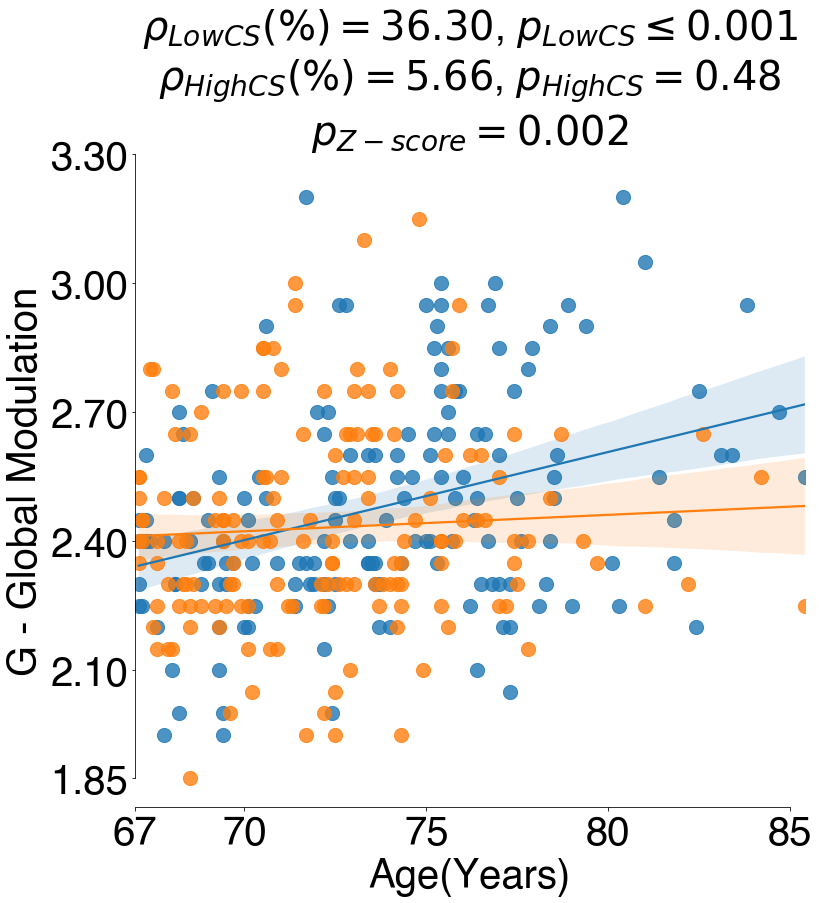

In [53]:
import seaborn as sns
path_root   = os.path.dirname(os.getcwd()) 



cmap = plt.get_cmap()
f,ax = plt.subplots(figsize=(12,12))

row_idx = 0
col_idx = 0

palette = sns.color_palette("husl", 8)


font_size = 40
feat_list = ['FC-FCemp CORR','G - Global Modulation','Noise','SC inter']


p_idx    = 1

mymat    = X_TUNE[:,p_idx]


cc_sc    = mymat
age_cc   = myage_list
# mycs     = list(verbalmemory[loc_plist_cs])
mycs     = list(concept_shifting[loc_plist_cs]*(-1))
mygender_cs  = np.array(gender_list_cs)[loc_plist_cs]
myedu_cs     = np.array(education_CS[loc_plist_cs])
# age_cc    = list(subj_age_CS[loc_plist_cs])

age_cc   = np.array(age_cc)[np.where(~np.isnan(cc_sc))[0]]
mygender_cs     = np.array(mygender_cs)[np.where(~np.isnan(cc_sc))[0]]
mycs     = np.array(mycs)[np.where(~np.isnan(cc_sc))[0]]
myedu_cs = np.array(myedu_cs)[np.where(~np.isnan(cc_sc))[0]]
cc_sc    = np.array(cc_sc)[np.where(~np.isnan(cc_sc))[0]]

cs_thr   = mycs>np.nanmedian(mycs)

AGE_THR = 67

mycs     = np.array(mycs)[age_cc>AGE_THR]
mygender_cs     = np.array(mygender_cs)[age_cc>AGE_THR]
myedu_cs     = np.array(myedu_cs)[age_cc>AGE_THR]
cc_sc    = np.array(cc_sc)[age_cc>AGE_THR]
cs_thr   = np.array(cs_thr)[age_cc>AGE_THR]
age_cc   = np.array(age_cc)[age_cc>AGE_THR]

age_cc_2   = age_cc[mycs>np.nanmedian(mycs)]
cc_sc_2    = cc_sc[mycs>np.nanmedian(mycs)]
mycs_2     = mycs[mycs>np.nanmedian(mycs)]


age_cc_1   = age_cc[mycs<=np.nanmedian(mycs)]
cc_sc_1    = cc_sc[mycs<=np.nanmedian(mycs)]
mycs_1     = mycs[mycs<=np.nanmedian(mycs)]

edu_sc_1   = myedu_cs[mycs<=np.nanmedian(mycs)]
edu_sc_2   = myedu_cs[mycs>np.nanmedian(mycs)]

sex_sc_1   = mygender_cs[mycs<=np.nanmedian(mycs)]
sex_sc_2   = mygender_cs[mycs>np.nanmedian(mycs)]


#     cc_sc    = np.array(cc_sc)[np.array(age_cc)>60]
#     age_cc   = np.array(age_cc)[np.array(age_cc)>60]

#     if p_idx == 4:
#         age_cc   = np.array(age_cc)[cc_sc<0.12]
#         cc_sc    = np.array(cc_sc)[cc_sc<0.12]

slope1, intercept1, r_value1, p_value1, std_err = stats.linregress(age_cc_1,cc_sc_1)
cc_hat_1 = slope1*age_cc_1 + intercept1
# r_value1 = r_value1*1e2

slope2, intercept2, r_value2, p_value2, std_err = stats.linregress(age_cc_2,cc_sc_2)
cc_hat_2 = slope2*age_cc_2 + intercept2
# r_value2 = r_value2*1e2
# data_reg = pd.DataFrame(
#         {'age':age_cc,
#         'feat_cc':cc_sc})

data_reg = pd.DataFrame(
        {'age':age_cc,
        'feat_cc':cc_sc,
        'cs_thr':cs_thr})

data_reg_1 = pd.DataFrame(
        {'age':age_cc_1,
        'feat_cc':cc_sc_1})

data_reg_2 = pd.DataFrame(
        {'age':age_cc_2,
        'feat_cc':cc_sc_2})

#     ax[row_idx,col_idx].scatter(age_cc,cc_sc,s=90)

separator = ''
str_yaxis = separator.join(feat_list[p_idx])

mytit     = separator.join([r'$\rho_{LowCS}(\%) =36.30$, $p_{LowCS} \leq 0.001$','\n',r'$\rho_{HighCS}(\%)=5.66$, $p_{HighCS} = 0.48$','\n','$p_{Z-score} = 0.002$'])

# sns.jointplot(data=data_reg, x="age", y="feat_cc", hue="cs_thr",kind='kde')
sns.regplot(data=data_reg_1, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
sns.regplot(data=data_reg_2, x="age", y="feat_cc",scatter_kws={"s": 200},ax = ax)
#     sns.regplot(x="age", y="feat_cc", data=data_reg,scatter_kws={"s": 200},ax = ax[row_idx,col_idx],ci=None)
ax.set_title(f'r_b(%) ={r_value1.round(3)},pv_b ={p_value1.round(3)},r_o.ge(%) ={r_value2.round(3)},pv2_o.ge ={p_value2.round(3)}',fontsize=font_size);

ax.set_title(mytit,fontsize=font_size);
ax.set_xlabel("Age(Years)",fontsize=font_size)
ax.set_ylabel(str_yaxis,fontsize=font_size);
ax.tick_params(axis='x', labelsize=font_size)
ax.tick_params(axis='y', labelsize=font_size)

plt.tick_params(axis='x', labelsize=font_size)
plt.tick_params(axis='y', labelsize=font_size)


ax.set_xticks([67, 70, 75, 80, 85])
ax.set_yticks([1.85,2.1,2.4,2.7,3.0,3.3])
sns.despine(trim=True)


csh_rep        = mycs>np.nanmedian(mycs)
gender_rep     = mygender_cs
edu_rep        = myedu_cs
G_POST_RESHAPE = cc_sc

df_SC          = pd.DataFrame({'csh':csh_rep ,'gcoup':G_POST_RESHAPE,'age':age_cc,'sex':gender_rep,'edu':edu_rep})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_sex = pg["r"][0]
p_corr_sex = pg["p-val"][0]

# print(r_corr_sex)
# print(p_corr_sex)

edu_rep_1        = edu_sc_1
G_POST_RESHAPE_1 = cc_sc_1

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_1,'age':age_cc_1,'edu':edu_sc_1,'sex':sex_sc_1})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_edu = pg["r"][0]
p_corr_edu = pg["p-val"][0]

edu_rep_2        = edu_sc_2
G_POST_RESHAPE_2 = cc_sc_2

df_SC          = pd.DataFrame({'gcoup':G_POST_RESHAPE_2,'age':age_cc_2,'edu':edu_sc_2,'sex':sex_sc_2})
pg             = partial_corr(data=df_SC, x='gcoup', y='age', covar=['sex','edu'])
r_corr_edu_2 = pg["r"][0]
p_corr_edu_2 = pg["p-val"][0]


print(f'r_b(%) ={r_corr_edu.round(4)}')
print(f'pv_b ={p_corr_edu.round(9)}')

print(f'r_o.ge(%) ={r_corr_edu_2.round(4)}')
print(f'pv2_o.ge ={p_corr_edu_2.round(6)}')


In [54]:
import scipy.stats as st

rvalue1_z = (np.log(1+r_corr_edu)-np.log(1-r_corr_edu))/2
rvalue2_z = (np.log(1+r_corr_edu_2)-np.log(1-r_corr_edu_2))/2

s_zdiff   = np.sqrt(1/(len(age_cc_1)-3)+1/(len(age_cc_2)-3))
Z_diff    = (rvalue1_z-rvalue2_z)/s_zdiff
p_diff    = 1-st.norm.cdf(Z_diff)
print(rvalue1_z)
print(rvalue2_z)
print(s_zdiff)
print(Z_diff)
print(p_diff)

0.38043565267855933
0.05663466807666873
0.11268780180500013
2.873434208630761
0.002030178190313925
